# Scramping da Linkedin
Schema di massima
```
Elenco (manuale o automatico) di link - vai a 2a. o 2b.
(pagine, profili, ecc.)
        |________ a. Per ogni link recuperare altri link - torna al primo passo.
        |             (es. tutti gli utenti di una pagina, di un # ecc.)
        |________ b. Per ogni link recuperare i dati che servono 
```
Flow
```
1. list_uni.csv (Link delle univesità)
  |
  |__ 2. list_users_2022-08-10.csv Link ai profili
      |__ 2a. list_users_2022-08-10.csv - left join - list_uni.csv
          |
          |__ 3. users_info_2022-08-10.csv Scraping informazioni
              |__ 3a. users_info_2022-08-10.csv  - left join - list_users_2022-08-10.csv
          |
          |__ 4. users_exp_2022-08-10.csv Scraping esperienza
              |__ 4a. users_exp_2022-08-10.csv  - left join - list_users_2022-08-10.csv
          |
          |__ 5. users_form_2022-08-10.csv Scraping formazione
              |__ 5a. users_form_2022-08-10.csv  - left join - list_users_2022-08-10.csv
          |
          |__ 6. users_lic_2022-08-10.csv Scraping licenze e certificazioni
              |__ 6a. users_lic_2022-08-10.csv  - left join - list_users_2022-08-10.csv

```
Vengono creati per il dw 4 .csv che potrebbero corrispondere a 4 tabelle di un db o a 4 db analitici.

users_info.csv è alla prima forma normale mentre tutti gli altri sono denormalizzati.

Ogni tabella denormalizzata può essere messa in join con users_info e quindi con ogni altra tabella.

**users_info**
*   ogni record rappresenta un profilo utente Linkedin
*   primary key = _id
*   foreign key = _id_uni (con _id di list_uni)

**user_exp**
*   ogni record rappresenta una esperienza di studio di un profilo utente
*   primary key = _id
*   foreign key = _id_user (users_info)

**user_form**
*   ogni record rappresenta una esperienza di formazione di un profilo utente
*   primary key = _id
*   foreign key = _id_user (users_info)

**user_lic**
*   ogni record rappresenta una licenza di un profilo utente
*   primary key = _id
*   foreign key = _id_user (users_info)

<br>

Altre tabelle

**list_uni**
*   ogni record rappresenta una pagina Linkedin di una università
*   primary key = _id

**list_users**
*   ogni record rappresenta un profilo utente Linkedin
*   primary key = _id
*   foreign key = _id_uni (con _id di list_uni)
<br>

------------------------

Il codice che segue (in **Python 3.7**, quello di Colab) funziona alla data del **10 agosto 2022** con le versioni delle lib corrispondenti a quelle di Colab.


## 0. Pre-requisiti


**1.   Uno o meglio più account Linkedin**

Perchè un profilo Linkedin sia utilizzabile per lo scraping deve avere sbloccate tutte le funzionalità. Occorre quindi avere una rete di contatti minima. Un profilo appena aperto senza nessun contatto non potrà visualizzare altri profili.

**2.   Account Premium**

Ci sono diversi profili premium che offrono specifiche funzionalità. Queste funzionalità non servono per lo scraping. L'account premium permette però di poter visualizzare più contenuti in una singola sessione. Un account free ha delle limitazioni importanti: nella stessa sessione o in sessioni consecutive, dopo un certo numero di profili visitati o pagine scrollate il sistema impedisce la visualizzazione di ulteriori profili. La visualizzazione quasi illimitata di profili per ogni sessione è una delle funzionalità a pagamento.

**3.   Pazienza**

Linkedin non ama lo scraping, come molti social. Quindi occorre pazienza, limitare il numero di pagine o profili visitati per ogni sessione e lasciar passare circa 10 ore tra una sessione e l'altra. Pena il banner tombale e perpetuo. Poter alternare lo scraping da più account e averli premium limita i danni, ma non li elude.

Pazienza anche nei test: quando cercate gli elementi della pagina fatelo su una sola pagina di prova alla volta, non nel for loop!!!



### Account Premium
Istruzioni

Presupponendo che non vogliamo pagare per fare scraping (no tool a pagamento o servizi vari offerti dai social), **come avere un account premium senza sborsare?**
<br><br>
Corrompere il business di Linkedin è impossibile, ma si possono sfruttare le promozioni. Per ogni account free c'è la possibilità di **attivare una prova gratuita di un mese** ad un account premium.
<br><br>
Se il profilo ha già attivato in passato l'opzione premium e poi è stata disdetta (prima o dopo il periodo di prova gratuito) Linkedin tornerà ad offrire una prova gratuita solo dopo un certo lasso di tempo (qualche mese di solito, ma dipende).
<br><br>
Ecco come attivare la prova gratuita.


**Loggatevi al vostro profilo e cliccate in alto a dx.**

IMPORTANTE!!

*   Controllate prima di aver registrato il vostro numero di telefono nel vostro account. Servirà per i passaggi successivi. Nel caso fatelo. 
*   Dovete avere una modalità di pagamento (PostePay o robe simili accettate da Linkedin)


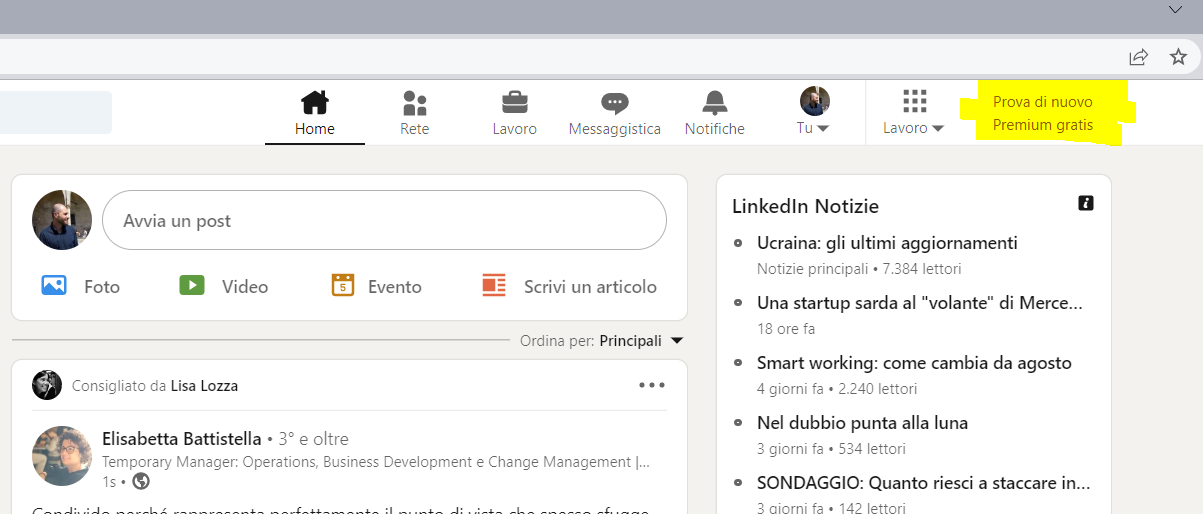

**Selezionate in basso a sx "Vedi tutti i piani"**

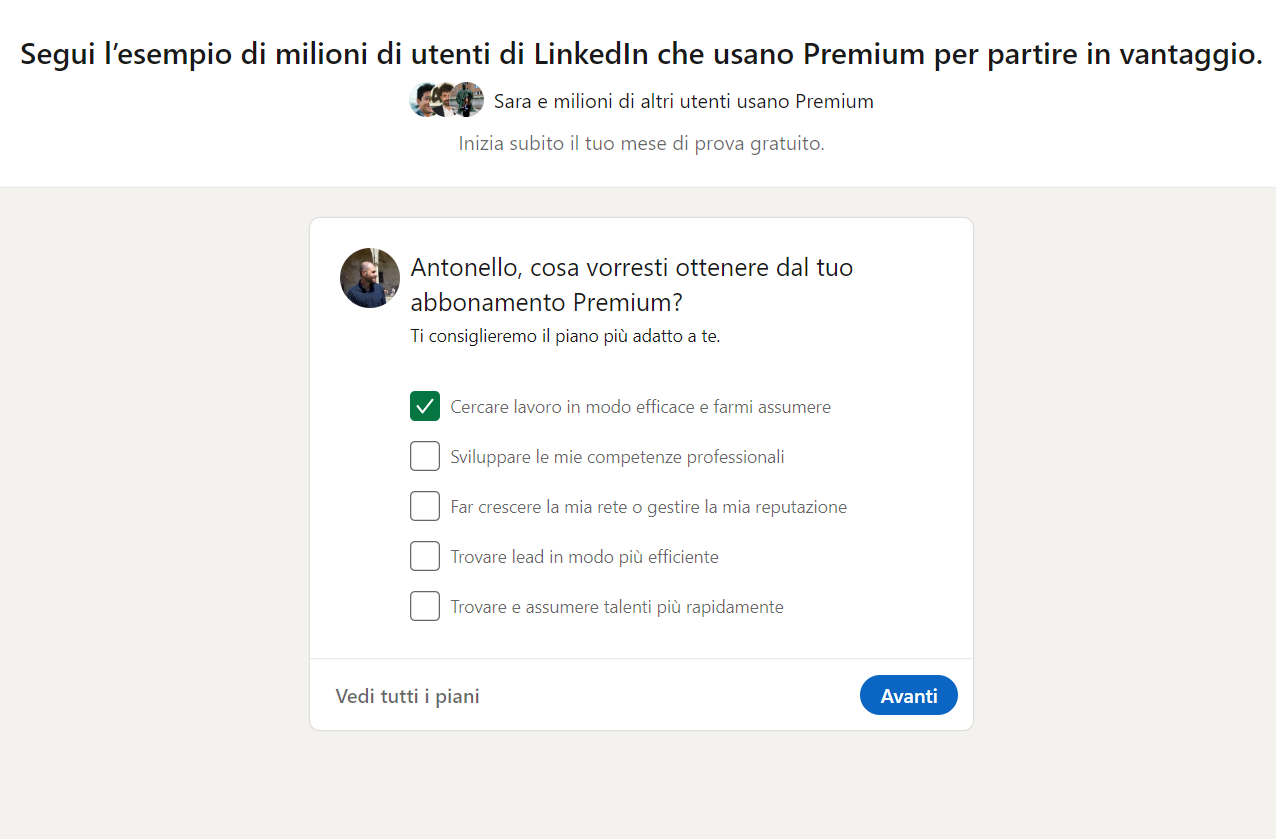

Vedrete l'elenco di tutte le tipologie di account premium. **Io ho scelto Recruiter Lite**. Cliccate su "Per saperne di più". La pagina scrollerà al punto desiderato.

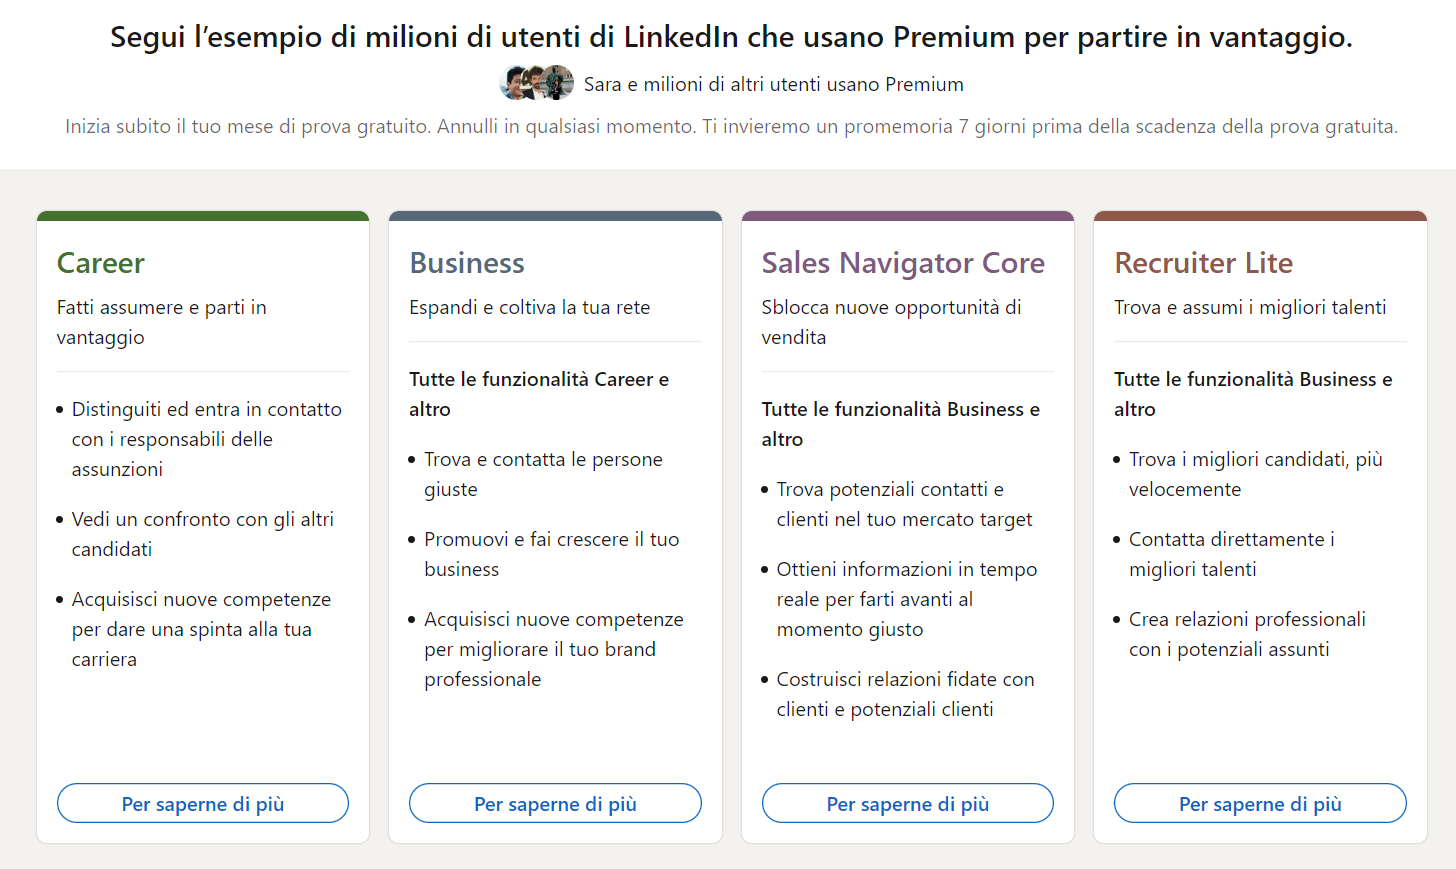

**Cliccate su "Prova di nuovo Premium gratis. Se non avete mai attivato premium la voce sarà una cosa tipo "Prova Premium gratis".**

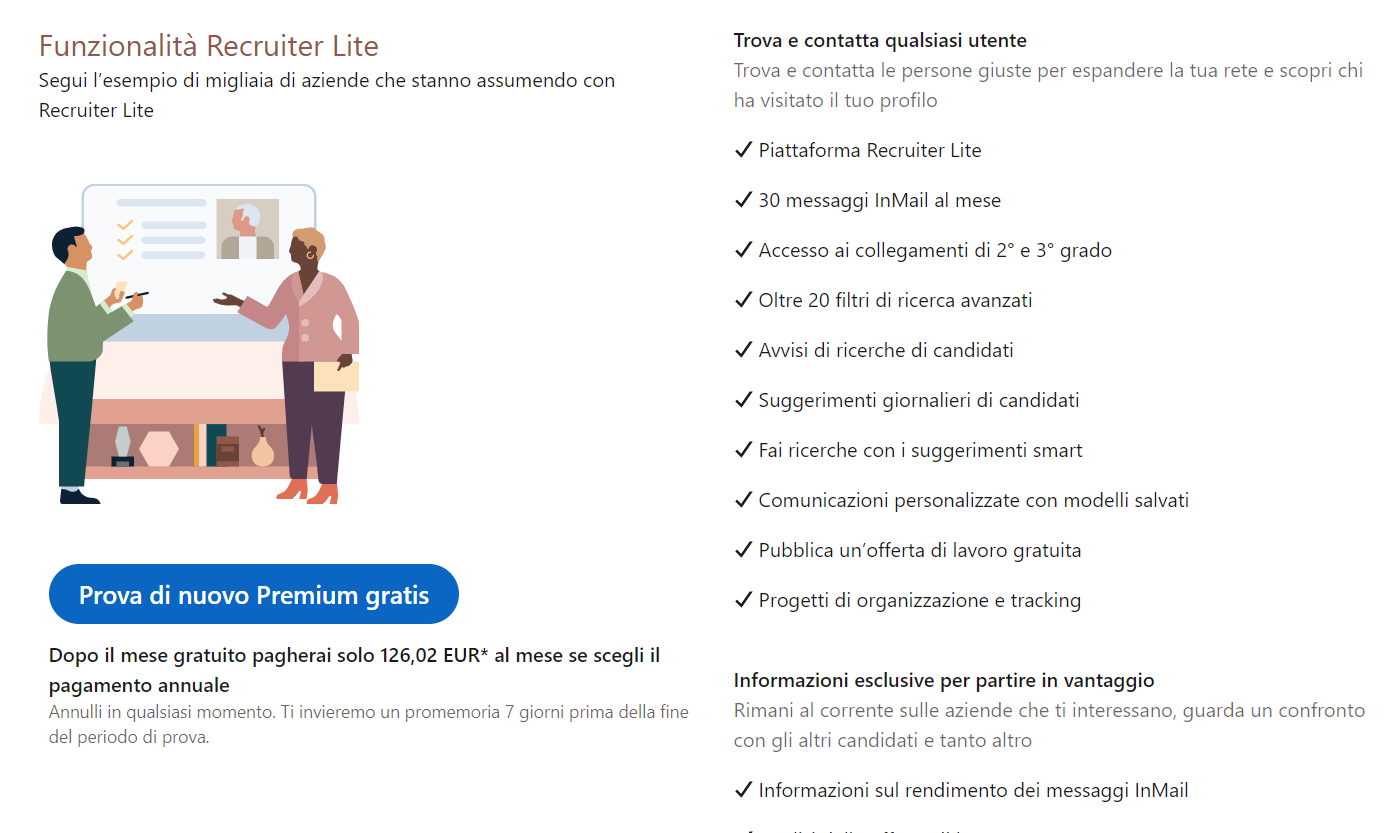

**Comparirà questa finestra. Loggatevi se non l'avete già fatto. Se invece siete già loggati questa finestra scomparirà dopo pochi secondi.**

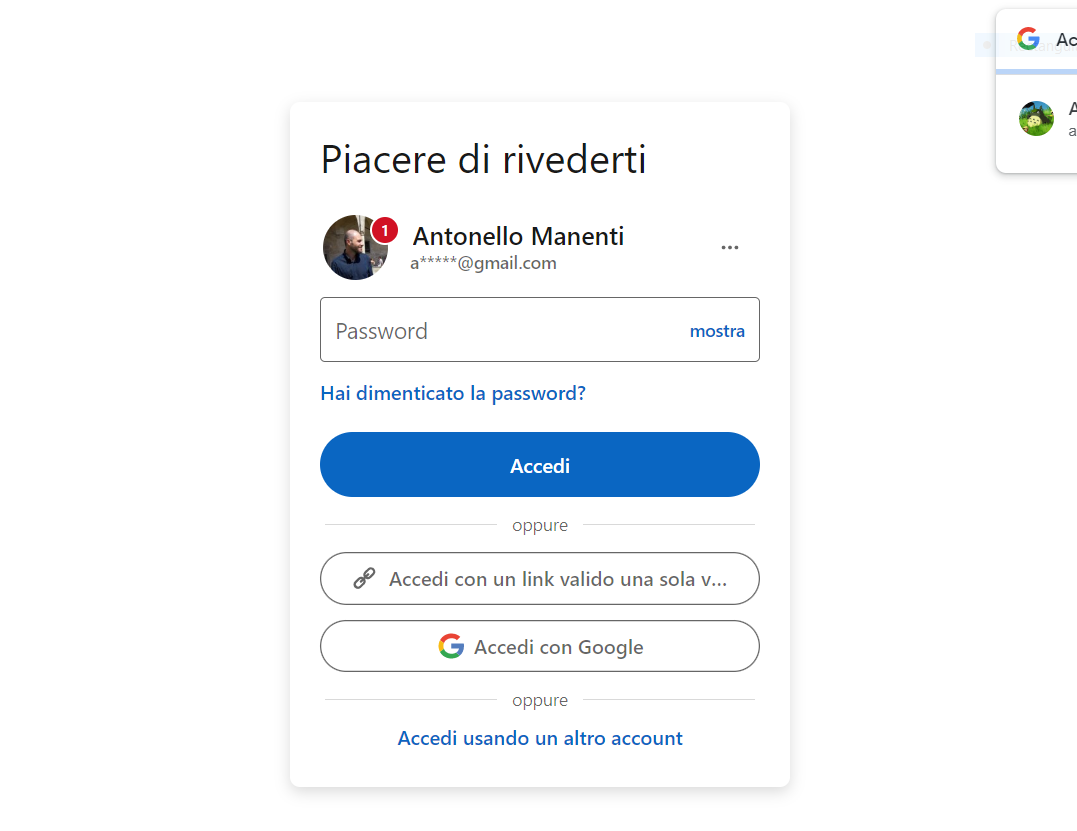

**Vi verrà inviato un messaggio sul cellulare che avete registrato.**

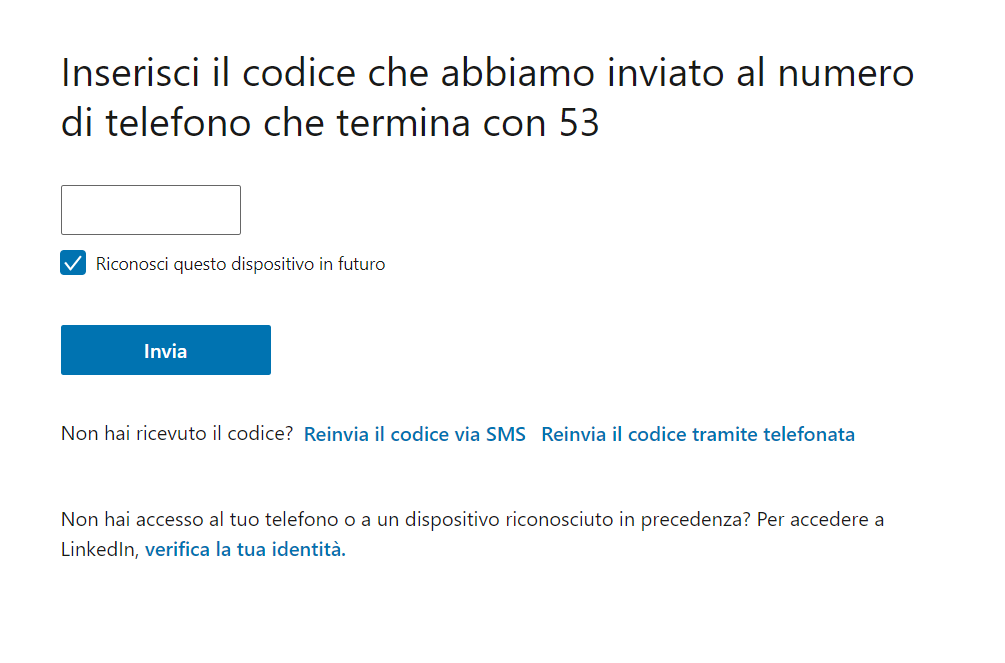


**Arriverete a questa schermata. Occhio al prezzo!!!!!!**

Scrollate.


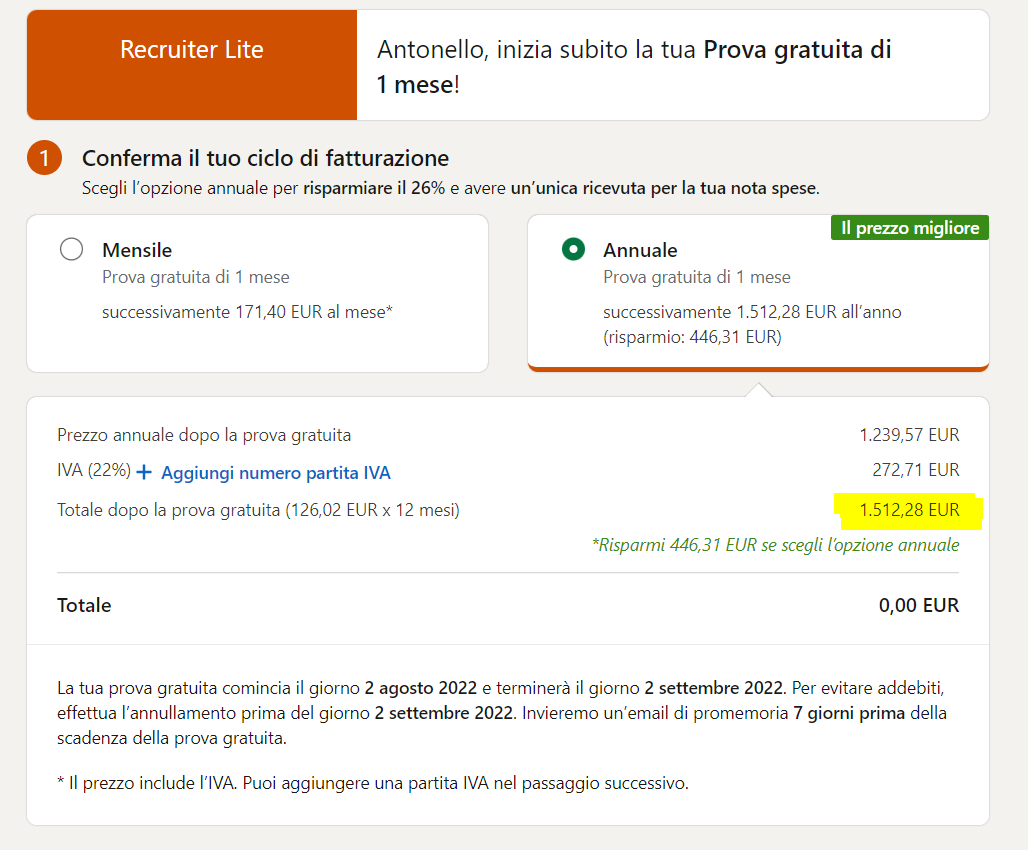

**Arrivati a questo punto clicate su "Inizia la prova gratuita".**

**ATTENZIONE!** Esattamente dopo i 30 giorni di prova gratuita Linkedin vi addebiterà l'intero importo annuale. DISATTIVATE l'opzione premium quanche giorno prima!

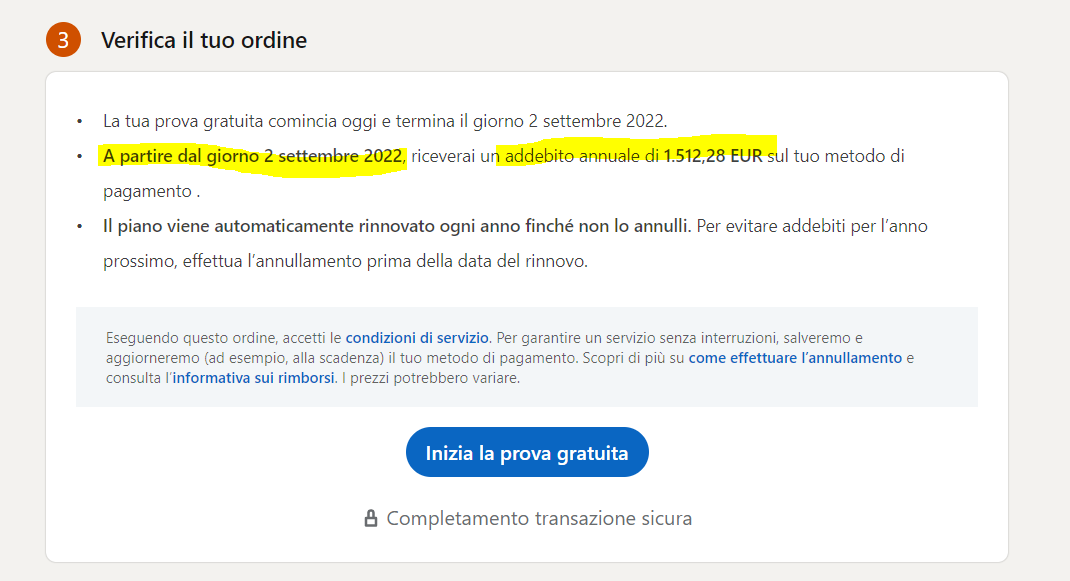

Conclusi questi step si può iniziare a fare scaping.

Per lo scraping useremo:


*   **GoogleDrive (ingest)**
*   **Colab (scraping)**

Pre-processing, ETL, processing, modellazione, creazione di DW o DataLake, analisi statistiche, A.I., ecc. non verranno trattate in questo notebook.






## 1. Elenco manuale di link
Prima definisco le paths dove mettere i miei file. Sono le path nel mio account, voi create le vostre!

Successivamente creo manualmente (GSheet o un excel che poi carico nella path) un elenco di pagine Linkedin da cui fare scraping.

Si tratta nel nostro esempio di un elenco di 20 pagine di altrettante università italiane.

Preparo manualmente un csv (scarico GSheet o l'excel caricato come .csv e lo metto in Drive nella path giusta) con un elenco di 20 università che ha come attributi:



`Università` *(è il nome LinkedIn dell'università)*


`Link` *(è l'url LinkedIn della pagina dell'università)*

`ID_uni` *(corrisponde all'url LinkedIn della pagina dell'università che utilizzo come ID univoco)*

`Link_ex_studenti` *(è il link LinkedIn all'elenco degli ex-stundeti dell'università)*


In [1]:
# monto GoogleDrive

from google.colab import drive
drive.mount('/content/drive')

# eseguendo il codice sopra potrete connettervi a qualsiasi account google di cui disponete user e pass

# Si possono visualizzare in Pandas direttamente i gsheet senza scaricarli e poi ricaricarli come .csv
# questo il link al notebook di documentazione:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=J4QxBareshEV
# Qui abbiamo usato i .csv. Il vantaggio di leggere direttamente i gsheet c'è solo se ci sono frequenti aggiornamenti automatici al foglio.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os # libreria che consente di comunicare con il sistema operativo. Qui la usiamo per creare, modificare ecc. file e cartelle.
# un'altra importante libreria è specifica per fare operazioni su percorsi e cartelle: glob
# glob e os sono spesso usate insieme

In [3]:
# definisco le path. Se non esistono le creo.

main = "/content/drive/MyDrive/repo/"
repo_name = f'{main}scraping/'
project_name = f'{repo_name}linkedin/'
ingest = f'{project_name}ingest/'
staging_area = f'{project_name}staging_area/'

try:
  os.makedirs(ingest, exist_ok=False)
  # di default exist_ok è già False. Lo esplicito cmq per far capire che sfrutto il parametro
  # per verificare se la cartella esiste già o no.
  print(f'New path {ingest} created')
except:
  print(f'New path {ingest} already exist')

try:
  os.makedirs(staging_area, exist_ok=False)
  print(f'New path {staging_area} created')
except:
  print(f'New path {staging_area} already exist')

# os.makedirs crea una cartella e tutto il percorso precedente. Da errore se la foglia esiste già.
# se invece il percorso prima esiste già non da errore, se non c'è lo crea.

New path /content/drive/MyDrive/repo/scraping/linkedin/ingest/ already exist
New path /content/drive/MyDrive/repo/scraping/linkedin/staging_area/ already exist


In [4]:
# Importo Pandas e Numpy e leggo il contenuto del .csv
import pandas as pd
import numpy as np

ds_list_uni = pd.read_csv(staging_area + "Elenco_uni_in.csv")
ds_list_uni.head()

,Università,Link,Link_ex_studenti,ID_uni
0,Politecnico di Milano,https://www.linkedin.com/school/polimi/,https://www.linkedin.com/school/polimi/people/,https://www.linkedin.com/school/polimi/
1,Sapienza Università di Roma,https://www.linkedin.com/school/sapienzauniver...,https://www.linkedin.com/school/sapienzauniver...,https://www.linkedin.com/school/sapienzauniver...
2,Università degli studi di Palermo,https://www.linkedin.com/school/universita-deg...,https://www.linkedin.com/school/universita-deg...,https://www.linkedin.com/school/universita-deg...
3,Università degli Studi di Siena,https://www.linkedin.com/school/universita-di-...,https://www.linkedin.com/school/universita-di-...,https://www.linkedin.com/school/universita-di-...
4,Università degli Studi di Genova,https://www.linkedin.com/school/universit-degl...,https://www.linkedin.com/school/universit-degl...,https://www.linkedin.com/school/universit-degl...


Pandas censura i contenuti delle celle che superano un certo numero di caratteri, così come per le colonne e le righe.
I parametri possono essere personalizzati:
<br>
<br>

`pd.set_option('display.max_colwidth', None)`

Setta il num. max. di caratteri visibili per ogni cella della colonna

es. 50 = primi 50 caratteri

None = testo completo
<br>
<br>

`pd.set_option('display.max_columns', None)`

Setta il num. max. di colonne visibili

es. 50 = primi 50 caratteri

None = tutte le colonne
<br>
<br>

`pd.set_option('display.max_rows', None)`

Setta il num. max. di colonne visibili

es. 50 = primi 50 caratteri

None = tutte le colonne
<br>
<br>

Più parametri possono essere anche scritti così:

`pd.set_option('display.max_colwidth', 5, 'display.max_columns', 5, 'display.max_rows', 5)`
<br>
<br>

Per ripristinare i valori di default

```
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")
```
<br>
<br>

Per ripristinare tutti i valori di default

`pd.reset_option("^display")`
<br>
<br>
**Attenzione, le impostazioni si applicano a tutti di df pandas che verranno eseguiti in seguito.**
<br>
<br>

Se si vogliono settare le opzioni solo per un blocco ecco il codice

```
with pd.option_context("display.max_rows", 10, "display.max_columns", 5):
  ds_list_uni
```
qui (indentato) si visualizzano al massimo 10 righe e 5 colonne
<br>
<br>


`ds_list_uni`

qui (non indentato) si visualizza il df con le opzioni di defaul o con quelle settate con pd.set_option(...) fuori da `with`
<br>
<br>

Link alla documentaizone di Pandas https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

In [ ]:
# modifico il nome della colonna ID_uni in _id (compatibile con MongoDB)
ds_list_uni.rename(columns={"ID_uni": "_id"}, inplace=True)

In [5]:
# creo un codice alfanumerico al posto degli attuali valori di ID_uni

# attenzione, la creazione dell'hash non vuole valori float (e np.nan è di tipo float) e associa hash anche a spazio vuoto
# quindi prima faccio un check sui nan, poi sui float.
# nel caso trasformare float in str o int e i np.nan in valori vuoti ""

# il check si può fare semplicemente con infolib

# Importo Infolib
!pip install infolib
from infolib import info

# uso infolib
info(ds_list_uni)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 



Overview of dataframe 
 
 
 
 columns 
 rows 
 rows_whitout_NaN 
 rows_whit_NaN 
 rows_duplicate 
 rows_unique 
 memory_usage 
 
 
 
 
 dataframe 
 4 
 20 
 20 
 0 
 0 
 20 
 9.51 KB 
 
 
 Features 
 
 
 
 dtypes 
 not_NaN 
 NaN 
 unique 
 top 
 freq 
 min_len 
 max_len 
 
 
 
 
 Università 
 object 
 20 
 0 
 20 
 Politecnico di Milano 
 1 
 15 
 44 
 
 
 Link 
 object 
 20 
 0 
 20 
 https://www.linkedin.com/school/polimi/ 
 1 
 38 
 73 
 
 
 Link_ex_studenti 
 object 
 20 
 0 
 20 
 https://www.linkedin.com/school/polimi/people/ 
 1 
 45 
 80 
 
 
 ID_uni 
 object 
 20 
 0 
 20 
 https://www.linkedin.com/school/polimi/ 
 1 
 38 
 73 
 
 
 Sample of dataframe 
 
 
 
 Università 
 Link 
 Link_ex_studenti 
 ID_uni 
 
 
 
 
 10 
 Università Ca'​ Foscari Venezia 
 https://www.linkedin.com/school/cafoscari/ 
 https://www.linkedin.com/school/cafoscari/people/ 
 https://www.linkedin.com/school/cafoscari/ 
 
 
 5 
 Università degli Studi di Perugia 
 https://www.linkedin.com/school/universit-degli-studi-di-perugia/ 
 https://www.linkedin.com/school/universit-degli-studi-di-perugia/people/ 
 https://www.linkedin.com/school/universit-degli-studi-di-perugia/ 
 
 
 1 
 Sapienza Università di Roma 
 https://www.linkedin.com/school/sapienzauniversitadiroma/ 
 https://www.linkedin.com/school/sapienzauniversitadiroma/people/ 
 https://www.linkedin.com/school/sapienzauniversitadiroma/

In [ ]:
# se è il caso faccio le trasformazioni opportune
ds_list_uni['_id'] = ds_list_uni['_id'].replace(np.nan, "")
ds_list_uni['_id'] = ds_list_uni['_id'].astype(str)

In [7]:
# ora uso la libreria hashlib per creare il codice alfanumerico

import hashlib

_id = []

for i in ds_list_uni['_id']:
  if i != "":
    hash_object = hashlib.md5(i.encode())
    md5_hash = hash_object.hexdigest()
    _id.append(md5_hash)
  else:
    _id.append(np.nan)
ds_list_uni['_id'] = _id

In [6]:
# aggiungo la data odierna per indicare la data dell'ultimo aggiornamento

# importo le librerie
import time
import datetime
from datetime import date

ds_list_uni['last_update'] = date.today()

In [ ]:
# check finale
info(ds_list_uni)

Overview of dataframe 
 
 
 
 columns 
 rows 
 rows_whitout_NaN 
 rows_whit_NaN 
 rows_duplicate 
 rows_unique 
 memory_usage 
 
 
 
 
 dataframe 
 5 
 20 
 20 
 0 
 0 
 20 
 9.88 KB 
 
 
 Features 
 
 
 
 dtypes 
 not_NaN 
 NaN 
 unique 
 top 
 freq 
 min_len 
 max_len 
 
 
 
 
 Università 
 object 
 20 
 0 
 20 
 Politecnico di Milano 
 1 
 15 
 44 
 
 
 Link 
 object 
 20 
 0 
 20 
 https://www.linkedin.com/school/polimi/ 
 1 
 38 
 73 
 
 
 Link_ex_studenti 
 object 
 20 
 0 
 20 
 https://www.linkedin.com/school/polimi/people/ 
 1 
 45 
 80 
 
 
 _id 
 object 
 20 
 0 
 20 
 6d9583ea7098ab5aa335ad266987fe5a 
 1 
 32 
 32 
 
 
 last_update 
 object 
 20 
 0 
 1 
 2022-08-10 
 20 
 10 
 10 
 
 
 Sample of dataframe 
 
 
 
 Università 
 Link 
 Link_ex_studenti 
 _id 
 last_update 
 
 
 
 
 10 
 Università Ca'​ Foscari Venezia 
 https://www.linkedin.com/school/cafoscari/ 
 https://www.linkedin.com/school/cafoscari/people/ 
 d0b9f3945b9a50d0cd66e1b16575c133 
 2022-08-10 
 
 
 6 
 Università Cattolica del Sacro Cuore 
 https://www.linkedin.com/school/unicatt/ 
 https://www.linkedin.com/school/unicatt/people/ 
 18e3b86984188af74913f3ba7e7a976f 
 2022-08-10 
 
 
 4 
 Università degli Studi di Genova 
 https://www.linkedin.com/school/universit-degli-studi-di-genova/ 
 https://www.linkedin.com/school/universit-degli-studi-di-genova/people/ 
 cb6c1c652f83708ec656fd32afce88cc 
 2022-08-10

In [ ]:
# salvo sovrascrivendo il file .csv
today = date.today()
ds_list_uni.to_csv(f'{staging_area}list_uni_{today}.csv', index=False)
# index false se non vogliamo che il df sia indicizato. Siccome è già indicizzato non vogliamo un altra colonna Unnamed

## Scraping dei link dei profili degli ex-studenti per ogni pagina delle Università in elenco

Per ogni università in elenco estraggo dalla pagina "Link_ex_studenti" le seguenti informazioni:

`url_user` *(corrisponde all'url LinkedIn dell'user)*

`_id` *(***primary key**: corrisponde all'url LinkedIn dell'user a cui applicherò l'hash)*

`name_user` *(corrisponde nikname LinkedIn dell'user)*

`name_uni` *(corrisponde al nome in LinkedIn dell'università)*

`url_uni` *(corrisponde all'url LinkedIn dell'università)*

`_id_uni` *(***foreign key**: corrisponde all'hash del link LinkedIn dell'università)*

`url_uni_ex_st` *(corrisponde all'url del link LinkedIn della pagina degli studenti dell'università)*

`last_update` *(data dell'ultimo update)*


<br>
Attenzione: prima di iniziare a fare scraping navigate per bene le pagine dai cui scaricare i dati. Una volta capito cosa volete verificate che ciò che cercate ci sia effettivamente. Infine fatevi uno schemino tipo quello sopra.

In [8]:
# installo quello che serve
!apt-get update
!pip install urllib3
!pip install selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,533 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://se

In [9]:
import sys
import logging

from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

from tqdm import tqdm_notebook as tqdm

import json
import pprint
from bs4 import BeautifulSoup as bs
import requests
import re as re
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from random import randint

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# opzionale
'''
Potrebbe essere utile, ma lo sconsiglio, connettere il proprio
browser fantasma attraverso un proxy. Ci sono diverse librerie python
che permettono di fare questo:

http-request-randomizer
phantomjs
ecc.

Le lib permettono di collegarsi a siti gratuiti che offrono liste di indirizzi, ma quasi sempre la connessione è lenta, instabile o cade
e a conti fatti per lo scraping da linkedin non ho riscontrato nessun vantaggio.
'''

'\nPotrebbe essere utile, ma lo sconsiglio, connettere il proprio\nbrowser fantasma attraverso un proxy. Ci sono diverse librerie python\nche permettono di fare questo:\n\nhttp-request-randomizer\nphantomjs\necc.\n\nLe lib permettono di collegarsi a siti gratuiti che offrono liste di indirizzi, ma quasi sempre la connessione è lenta, instabile o cade\ne a conti fatti per lo scraping da linkedin non ho riscontrato nessun vantaggio.\n'

In [106]:
# imposto il browser fantasma
# qui trovate la documentazione link
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--window-size=1920,1080") # importante! a dimensioni diverse il css si modifica.
# Quando cercherete nel codice il css, l'id, l'xpath, ecc. fatelo visualizzando la finestra alla stessa larghezza che avete impostato in selenium.

chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

In [107]:
# attiviamo il browser
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

'''
per chiudere la finestra corrente del browser
wd.close()

per chiudere tutto
wd.quit()

'''

'\nper chiudere la finestra corrente del browser\nwd.close()\n\nper chiudere tutto\nwd.quit()\n\n'

In [113]:
# immetiamo nel browser i link
wd.get("https://www.linkedin.com/login/")
time.sleep(3) # attendo 3 secondi

In [114]:
# per comodità definisco una funzione per visualizzare il browser

def view():
  screenshot = "screenshot.png"
  wd.save_screenshot(screenshot)
  img=mpimg.imread(f'/content/{screenshot}')
  fig = plt.figure(figsize = (15,15), dpi=150.00)
  plt.axis('off')
  imgplot = plt.imshow(img)

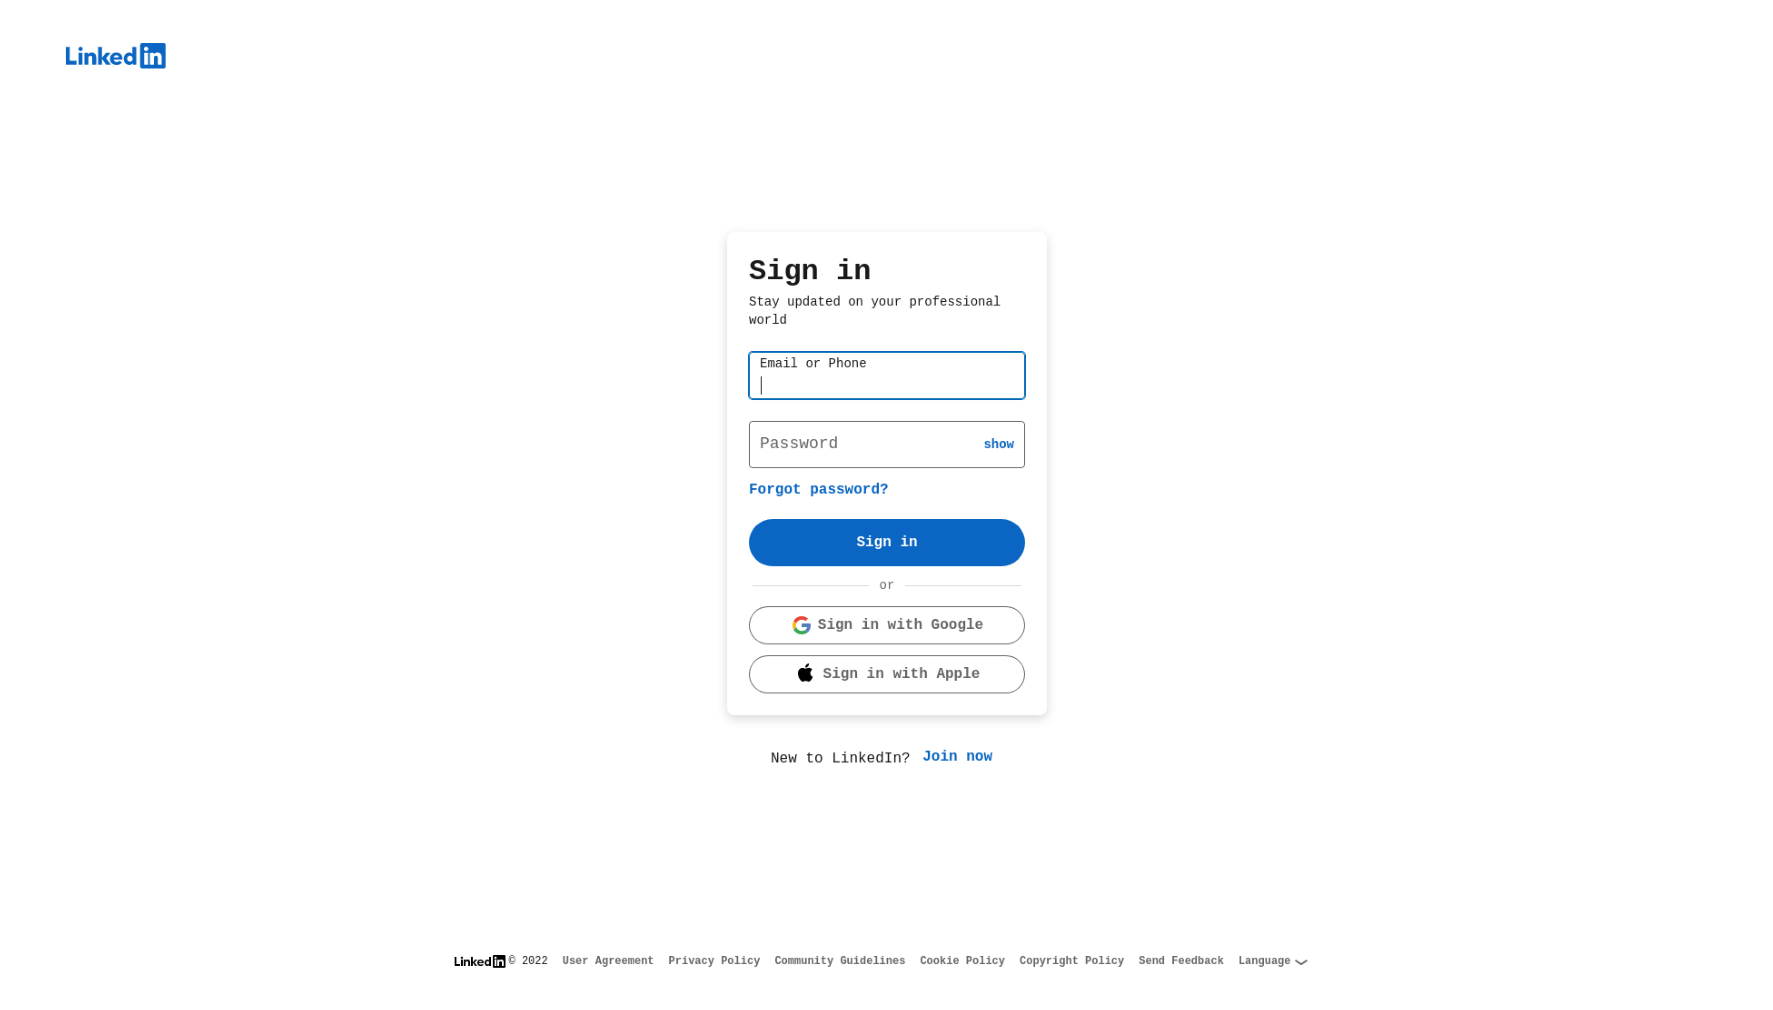

In [115]:
view()

In [ ]:
#creiamo delle variabili con i dati da immettere
USERNAME = input("Enter the username: ")
PASSWORD = input("Enter the password: ")

In [116]:
# inseriamo le variabili nei campi
email = wd.find_element(By.ID, "username")
email.send_keys(USERNAME)
password = wd.find_element(By.ID, "password")
password.send_keys(PASSWORD)
password.send_keys(Keys.ENTER)
time.sleep(3)

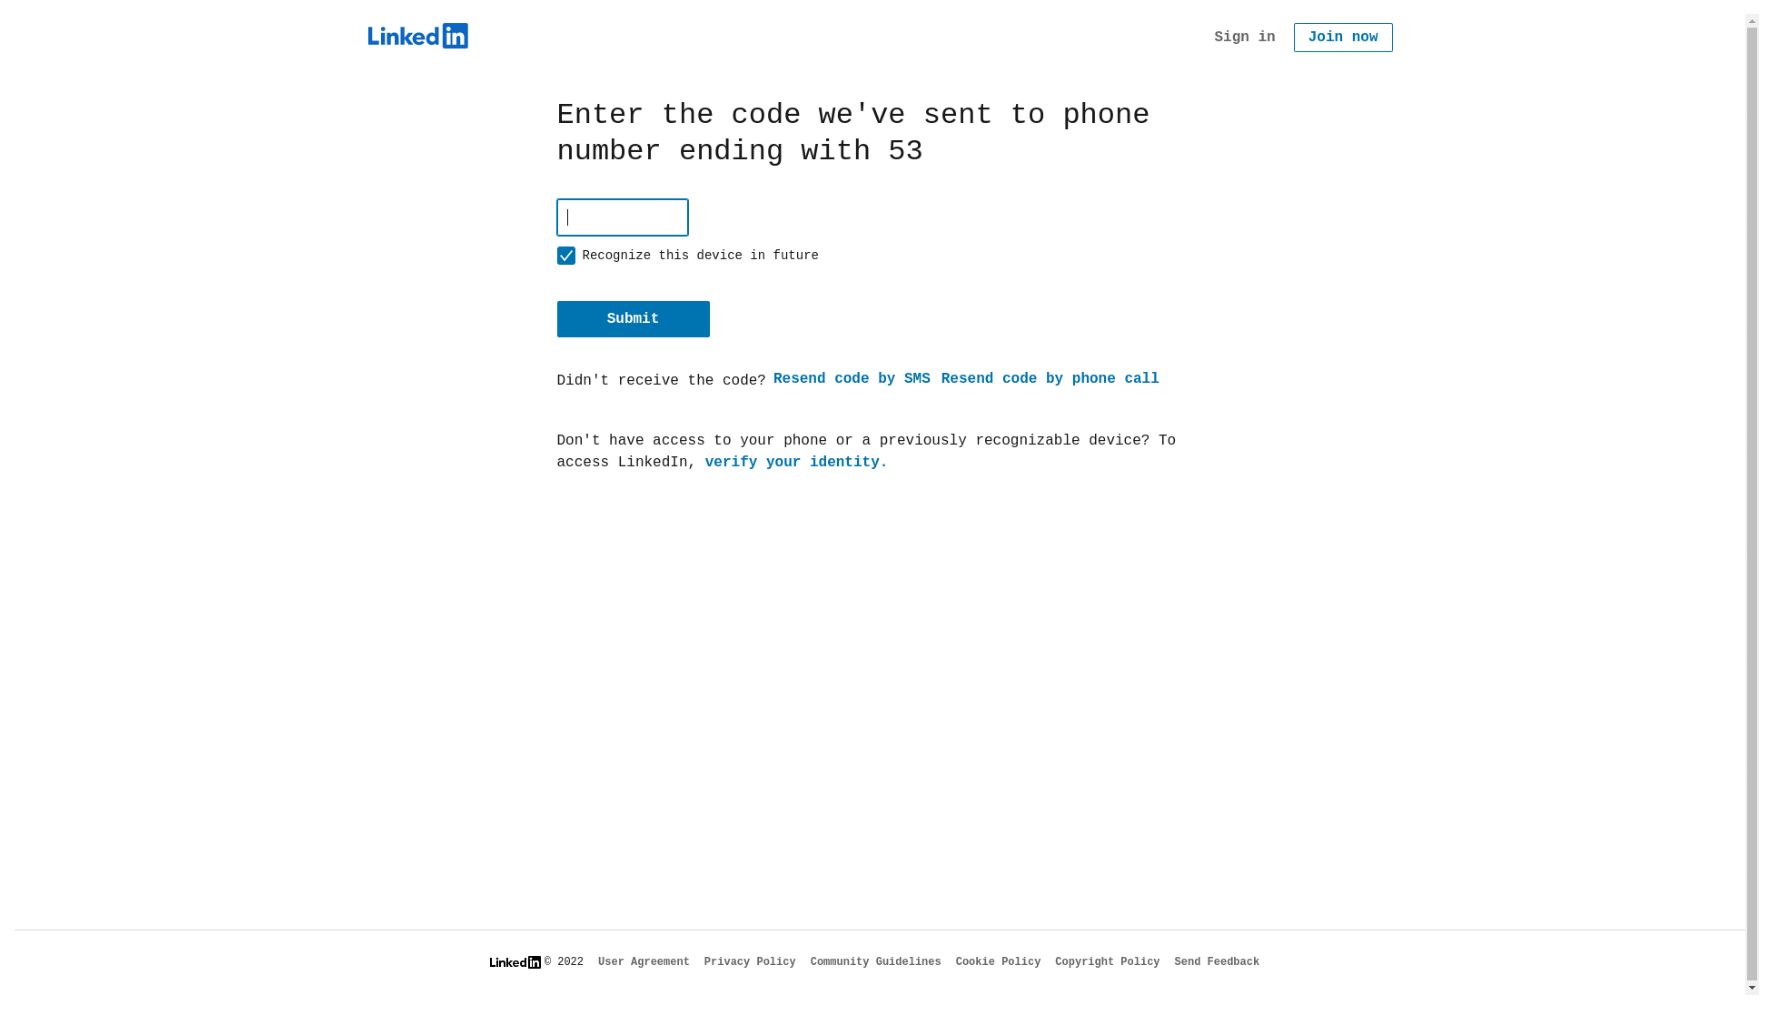

In [117]:
view()

A questo punto potreste essere reindirizzati a:


1.   La vostra home
2.   Un pagina in cui vi chiedono di inserire il codice inviatovi al numero di telefono che avete registrato
3.   Un pagina in cui vi chiedono di inserire il codice inviatovi via email
4. Compare un CAPTCHA

Nel caso di 2. e 3. procedere come segue, altrimenti saltare il passaggio. Nel caso 4. inventatevi qualcosa. A me non è mai capitato, quindi non mi sono posto il problema.

In [118]:
# 2. caso del numero di telefono
PIN = input("Enter the PIN: ")

pin = wd.find_element(By.ID, "input__phone_verification_pin")
pin.send_keys(PIN)
pin.send_keys(Keys.ENTER)
time.sleep(3)

Enter the PIN: 012998


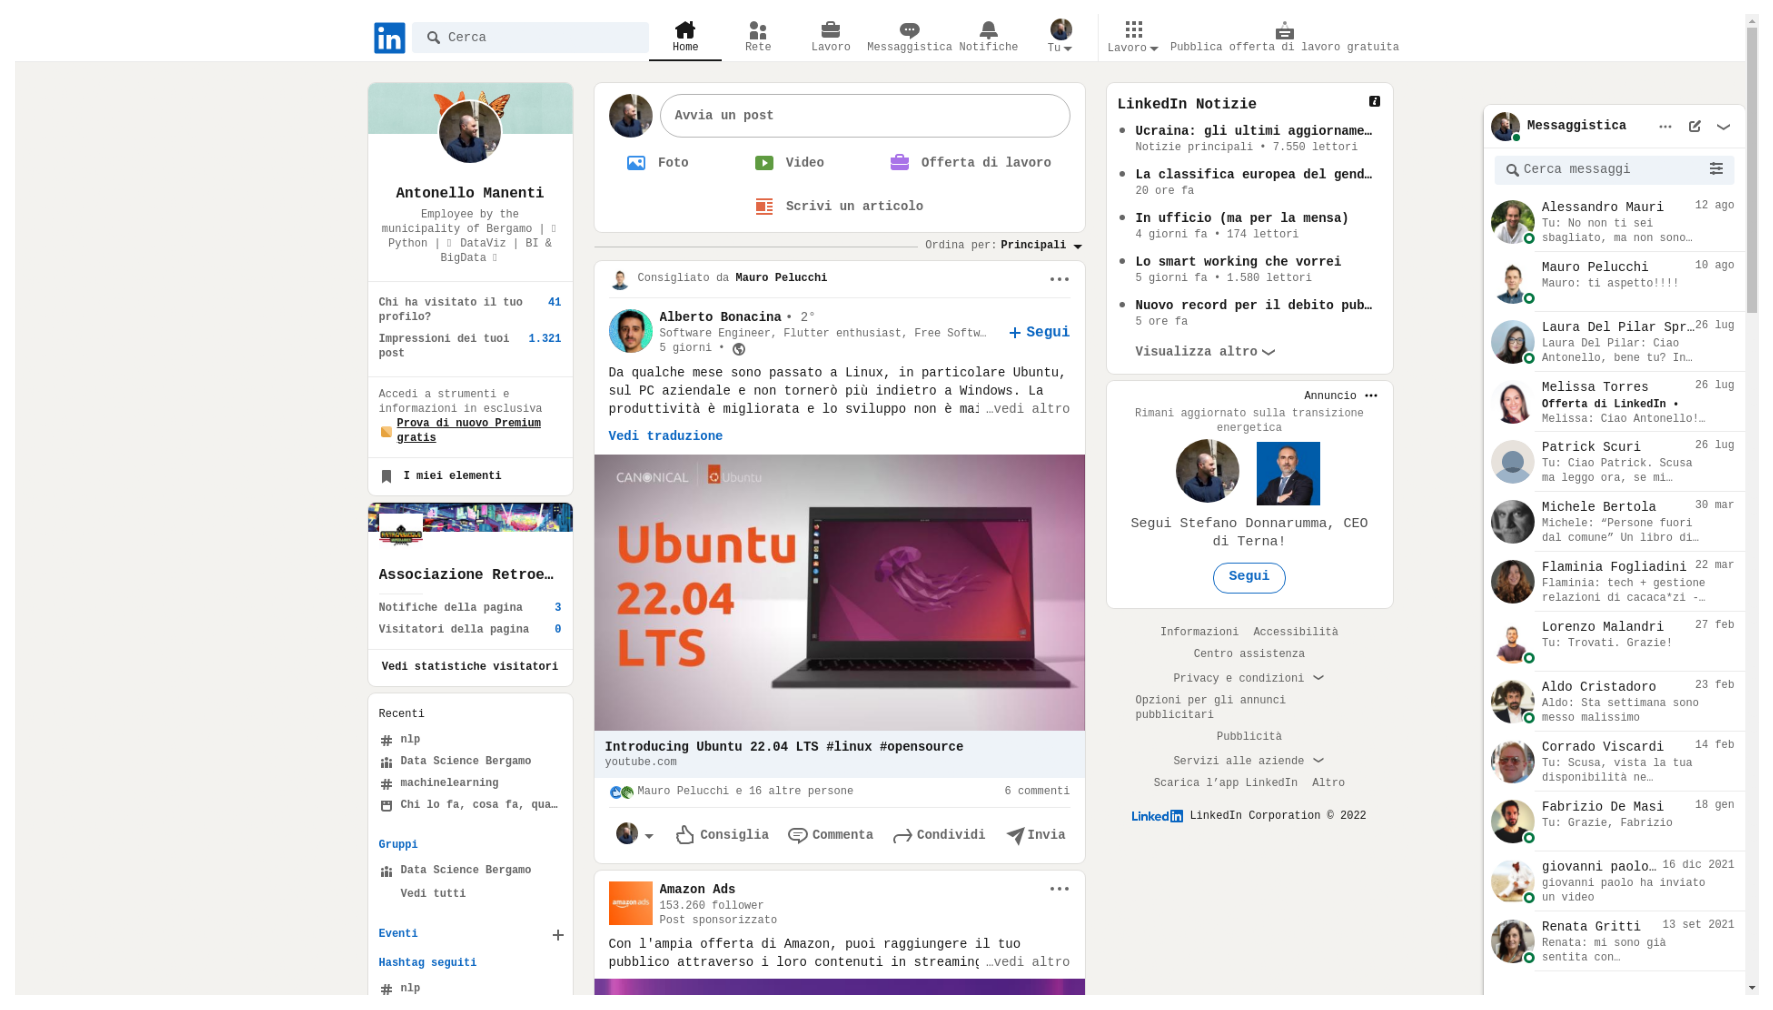

In [119]:
view()

In [ ]:
# se qualcosa è andato storto fatevi reinviare il codice e rifate i passaggi sopra
resend = wd.find_element(By.ID, "btn-resend-pin-sms")
resend.send_keys(Keys.ENTER)
time.sleep(3)

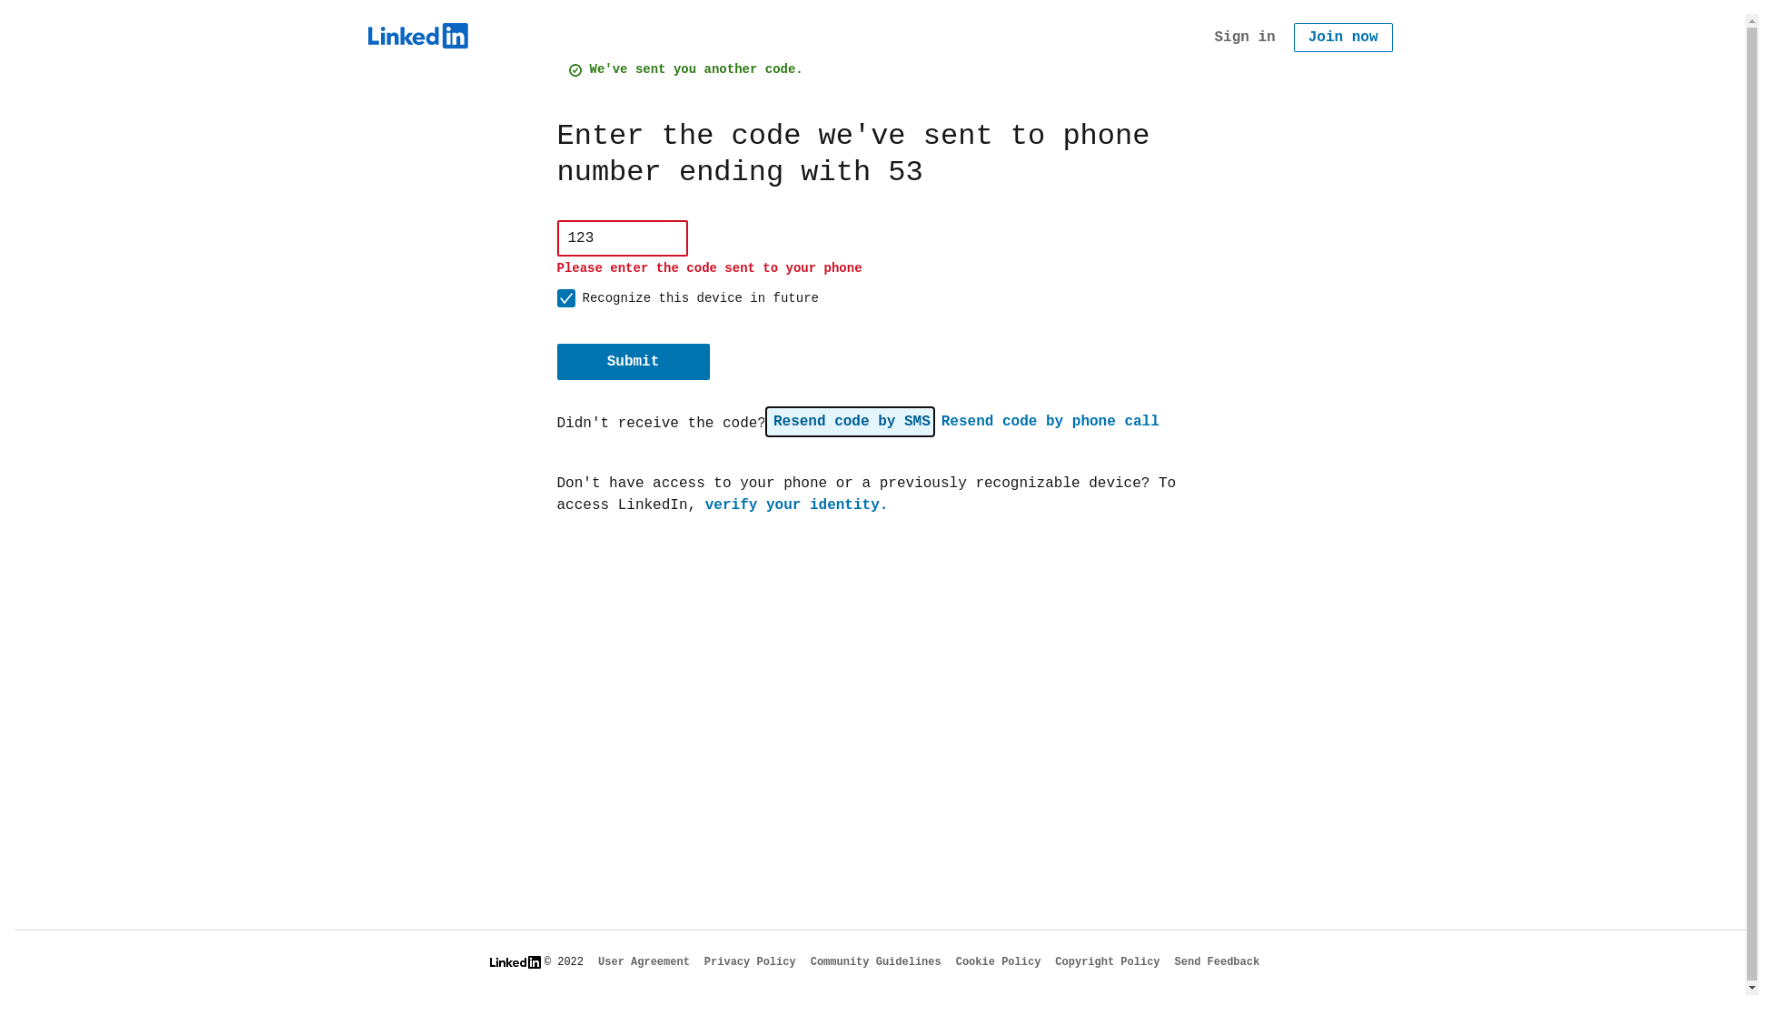

In [ ]:
view()

In [ ]:
# 3. caso della verifica via email
PIN = input("Enter the PIN: ")
print(PIN)

pin = wd.find_element_by_id("input__email_verification_pin")
pin.send_keys(PIN)
time.sleep(3)

In [ ]:
view()

Se ad un certo punto compare quanto segue, male.

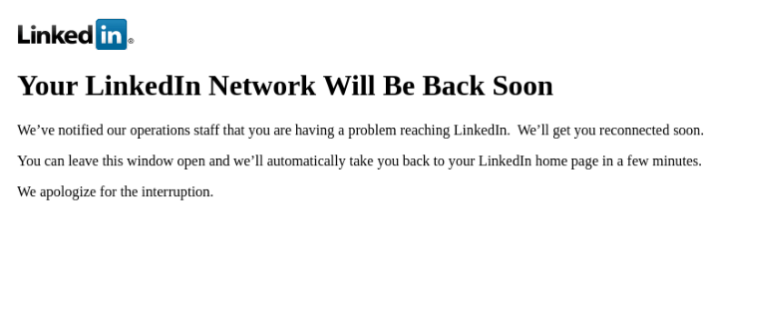

Infine potrebbe succedere che all'improvviso, mentre state facendo scraping, si rompe tutto senza apparente motivo. Controllate che non vi siano arrivate notifiche come questa, nel qual caso interrompete tutto e prendetevi una pausa.

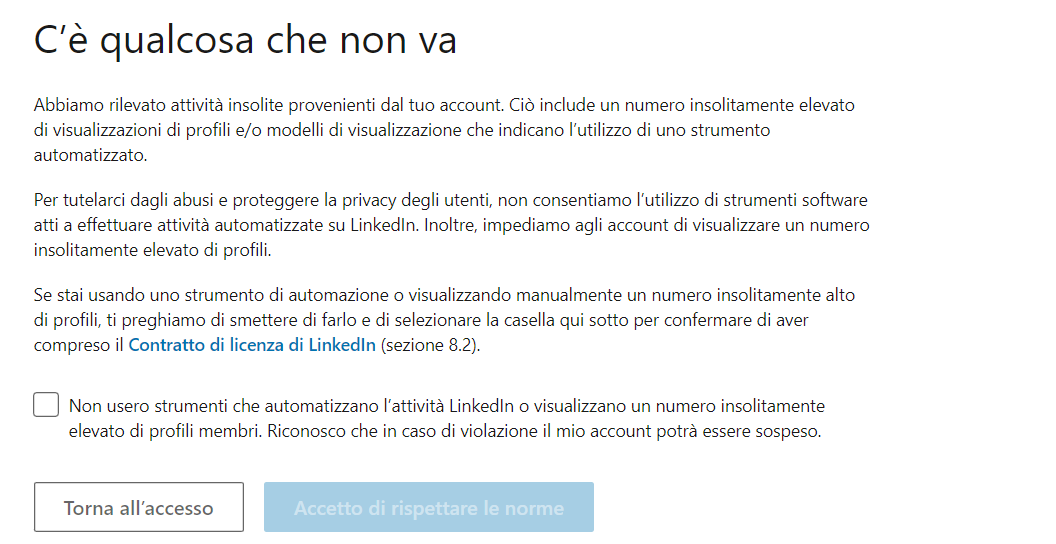

In [20]:
# prima di prendere ogni link dalla nostra lista definisco una funzione per far scrollare la pagina fino in fondo

def scroll(driver, timeout):
    scroll_pause_time = timeout

    # in questo modo si ottiene l'altezza della pagina. Serve per il ciclo while che proseguirà fino a quando l'ultima altezza
    # sarà uguale a quella precedente (cioè si è arrivati in fondo allo scroll)
    last_height = driver.execute_script("return document.body.scrollHeight")
    # .execute_script è un metodo che serve per far eseguire a Selenium codice JavaScript

    while True: # la condizione true proseguirà all'infinito. Ci sarà bisogno di impostare un break per dichiarare quando dovrà fermarsi.
        # qui scrolliamo da 0 (angolo assoluto in alto a sx) fino alla fine della pagina visibile
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # attendo 5 secondi, la pagina potrebbe impiegare un po' di tempo a caricarsi e se tento di proseguire
        # con lo scroll quando la pagina non è ancora carica Selium crederà di essere arrivato in fondo
        time.sleep(5)

        # arrivato in fondo e atteso 5 secondi linkedin, come facebook e altri, avrà caricato i risultati successivi
        #  la pagina si sarà quindi allungata. Ricalcolo l'altezza.
        new_height = driver.execute_script("return document.body.scrollHeight")
        
        if new_height == last_height:
            # se la pagina ha la stessa altezza di prima dello scroll siamo arrivati in fondo e ci fermiamo
            break
        print(f'current height: {new_height}')
        last_height = new_height # se if è False proseguo e dichiaro la nuova altezza, pari all'ultima altezza

Consiglio: quando scrollate le 20 pagine delle università vedrete che sulle prime pagine avrete parecchi profili, poi caleranno.

Non dovreste fare più di 3 pagine per ogni sessione, più concatenate pagine nella stessa sessione meno linkedin vi fa visualizzare profili. Dividete quindi in diversi subset e procedete un gruppo alla volta.

La cosa verrà lunga perchè per ogni subset dovrete interrompere, riavviare il runtime e riloggarvi con un altro profilo (alternate 2 o 3 profili).

In [ ]:
today = date.today()
ds_list_uni = pd.read_csv(f'{staging_area}list_uni_{today}.csv')

In [ ]:
ds_list_uni_3 = ds_list_uni.iloc[:3,:]
ds_list_uni_6 = ds_list_uni.iloc[3:6,:]
ds_list_uni_9 = ds_list_uni.iloc[6:9,:]
ds_list_uni_12 = ds_list_uni.iloc[9:12,:]
ds_list_uni_15 = ds_list_uni.iloc[12:15,:]
ds_list_uni_18 = ds_list_uni.iloc[15:18,:]
ds_list_uni_end = ds_list_uni.iloc[18:,:]

In [ ]:
list_users = [] # definisco una lista vuota
for index, project in tqdm(ds_list_uni_18.iterrows(), total = ds_list_uni_18.shape[0]):
    # total è un parametro facoltativo di tqdm e rappresenta il numero di iterazioni previste. shape da il numero di righe e colonne
    # shape[0] sono le righe, [1] le colonne
    # iterrows() restituisce 2 variabili: l'indice della riga del df e una serie indicizzata con tutti i valori di quella riga.
    # L'indice della serie corrisponde al nome delle colonne.
    # Ogni riga è quindi come se fosse un subset del df. 
    
    time.sleep(1)
    link = project["Link_ex_studenti"]
    # project è quindi una lista. series[label] corrisponde al valore indicizzato con una certa label nella lista
    # in una certa riga del dataframe, quella con indice index nel nostro for loop. La stessa cosa si può fare con project[0]
    # in cui [0] è la posizione della value nella serie.
    # la stessa sintassi frame[colname] ma applicata ad un dataframe da come risultato la serie dei valori di quella colonna.
    _id = project["_id"]
    # prendo da ds_list_uni anche l'id per mettere poi in join i 2 db: quello delle uni e quello degli users

    wd.get(link)
    time.sleep(3)

    # mi interessano solo i/le laureati/e tra il 2015 e il 2020
    start = wd.find_element(By.ID, "people-search-year-start")
    start.send_keys(2015)
    end = wd.find_element(By.ID, "people-search-year-end")
    end.send_keys(2020)
    end.send_keys(Keys.ENTER)
    time.sleep(3)
    
    scroll(wd, 5)

    list_profile = wd.find_elements(By.CLASS_NAME, "ember-view.link-without-visited-state")
    
    for i in list_profile: #list_profile è la lista dei profili definita sopra
      url_user = i.get_attribute('href')
      name_user = i.text

      list_users.append({'url_user': url_user,
                            'name_user': name_user,
                            '_id_uni': _id})

  0%|          | 0/3 [00:00<?, ?it/s]

current height: 3773
current height: 5045
current height: 6317
current height: 7589
current height: 8861
current height: 10133
current height: 11405
current height: 12677
current height: 13949
current height: 15221
current height: 16493
current height: 17765
current height: 19037
current height: 20309
current height: 21581
current height: 22853
current height: 24125
current height: 25397
current height: 26669
current height: 27941
current height: 29213
current height: 30485
current height: 31757
current height: 33029
current height: 34301
current height: 35573
current height: 36845
current height: 38117
current height: 39389
current height: 40661
current height: 41933
current height: 43205
current height: 44477
current height: 45749
current height: 47021
current height: 48293
current height: 49565
current height: 50837
current height: 52109
current height: 53381
current height: 54653
current height: 55925
current height: 57197
current height: 58469
current height: 59741
current height:

In [ ]:
list_users = pd.DataFrame(list_users)

In [ ]:
# aggiungo _id e data di scraping
_id = []

for i in list_users['url_user']:
  if i != "":
    hash_object = hashlib.md5(i.encode())
    md5_hash = hash_object.hexdigest()
    _id.append(md5_hash)
  else:
    _id.append(np.nan)
list_users['_id'] = _id
list_users['last_update'] = date.today()

In [ ]:
# metto join
result = pd.merge(list_users, ds_list_uni, how="left", left_on="_id_uni", right_on="_id", suffixes=("_user", "_univ"), validate="many_to_one")

In [ ]:
result.columns

Index(['url_user', 'name_user', '_id_uni', '_id_user', 'last_update_user',
       'Università', 'Link', 'Link_ex_studenti', '_id_univ',
       'last_update_univ'],
      dtype='object')

In [ ]:
# rinomino le colonne
result.rename(columns={"Università": "name_uni",
                       "_id_user" : "_id",
                       "Link" : "url_uni",
                       "Link_ex_studenti" : "url_uni_ex_st",
                       "last_update_user":"last_update"}, inplace=True)

# elimino la colonna '_id_univ'
col = ['_id_univ', 'last_update_univ'] # creo una lista con i nomi di colonne da eliminare

result = result.loc[:, ~result.columns.isin(col)]
# .loc che prende tutti i record :, e tutte le colonne che NON sono nella lista col

In [ ]:
info(result)

Overview of dataframe 
 
 
 
 columns 
 rows 
 rows_whitout_NaN 
 rows_whit_NaN 
 rows_duplicate 
 rows_unique 
 memory_usage 
 
 
 
 
 dataframe 
 8 
 2833 
 2833 
 0 
 59 
 2774 
 2.09 MB 
 
 
 Features 
 
 
 
 dtypes 
 not_NaN 
 NaN 
 unique 
 top 
 freq 
 min_len 
 max_len 
 
 
 
 
 url_user 
 object 
 2833 
 0 
 2765 
 https://www.linkedin.com/in/marta-lanzini-906730180/ 
 3 
 33 
 78 
 
 
 name_user 
 object 
 2833 
 0 
 2751 
 Marta Lanzini 
 3 
 6 
 42 
 
 
 _id_uni 
 object 
 2833 
 0 
 3 
 2de57da6afd61a831209197b965c07aa 
 964 
 32 
 32 
 
 
 _id 
 object 
 2833 
 0 
 2765 
 8e8602e235f2e70f28711dbc8ff93ed6 
 3 
 32 
 32 
 
 
 last_update 
 object 
 2833 
 0 
 1 
 2022-08-10 
 2833 
 10 
 10 
 
 
 name_uni 
 object 
 2833 
 0 
 3 
 Università degli Studi di Milano-Bicocca 
 964 
 18 
 40 
 
 
 url_uni 
 object 
 2833 
 0 
 3 
 https://www.linkedin.com/school/university-degli-studi-di-milano-bicocca/ 
 964 
 43 
 73 
 
 
 url_uni_ex_st 
 object 
 2833 
 0 
 3 
 https://www.linkedin.com/school/university-degli-studi-di-milano-bicocca/people/ 
 964 
 50 
 80 
 
 
 Sample of dataframe 
 
 
 
 url_user 
 name_user 
 _id_uni 
 _id 
 last_update 
 name_uni 
 url_uni 
 url_uni_ex_st 
 
 
 
 
 2583 
 https://www.linkedin.com/in/marco-maiolica/ 
 Marco Maiolica 
 a0e6d88092081e3a5566d41dd97a0dd2 
 b999cfa73f1907e8028668cfe1599ee6 
 2022-08-10 
 Università degli Studi di Salerno 
 https://www.linkedin.com/school/unisalerno/ 
 https://www.linkedin.com/school/unisalerno/people/ 
 
 
 1290 
 https://www.linkedin.com/in/gianluca-fazio-90b50b96/ 
 Gianluca Fazio 
 2de57da6afd61a831209197b965c07aa 
 d35bc5e8fae7e0ccd13c8f9d8e95f1b0 
 2022-08-10 
 Università degli Studi di Milano-Bicocca 
 https://www.linkedin.com/school/university-degli-studi-di-milano-bicocca/ 
 https://www.linkedin.com/school/university-degli-studi-di-milano-bicocca/people/ 
 
 
 213 
 https://www.linkedin.com/in/tobia-cingolani-09043a120/ 
 Tobia Cingolani 
 5b30c0de80cc809bf393d723ad82f95c 
 bce79e65b38fb14619ebd6c9f7151da7 
 2022-08-10 
 Università Bocconi 
 https://www.linkedin.com/school/universita-bocconi/ 
 https://www.linkedin.com/school/universita-bocconi/people/

In [ ]:
# elimino i doppioni (non si sa mai che qualcosa sia andato storto)
result = result.drop_duplicates(subset=['_id'])

In [ ]:
# salvo come csv
result.to_csv(staging_area + "ds_list_uni_18.csv", index=False)

In [ ]:
# e se avessi diviso i subset? Il procedimento è identico fino al punto sopra
# (ricordarsi ogni volta di rinomiare le variabili e salvare i file con i nomi corretti)
# si conclude unendo direttamente tutti i csv in questo modo

# creo una nuova cartella dove sposto tutti i file ds_list_uni_3 ecc. che ho creato

merge_area = f'{staging_area}merge_area/'

try:
  os.makedirs(merge_area, exist_ok=False)
  print(f'New path {merge_area} created')
except:
  print(f'New path {merge_area} already exist')

# sposto i file nella nuova cartella
# di fatto spostare è uguale a rinominare il percorso

import glob

for i in tqdm(glob.glob(f'{staging_area}ds_list_uni_*.csv')):
  try:
    basename = os.path.basename(i)
    os.rename(f'{staging_area}{basename}',f'{merge_area}{basename}')
    print(f'File moved')
  except Exception as e:
    print(e)

# ora unisco tutti i csv della cartella merge

# creo una lista di path di tutti i file che iniziano con list_users_ e finiscono con .csv
formazione_raw_all_files = glob.glob(os.path.join(merge_area, "ds_list_uni_*.csv"))

# importo in pandas ogni file con un ciclo for (versione "slim") e inserisco tutto in una variabile
formazione_raw_from_each_file = (pd.read_csv(f, sep=',') for f in formazione_raw_all_files)

# concateno tutti i pd
formazione_raw_merged = pd.concat(formazione_raw_from_each_file, ignore_index=True)

# elimino i doppioni: uno stesso user potrebbe essere ex-alunno di due università diverse e me lo troverei 2 volte nel df
formazione_raw_merged = formazione_raw_merged.drop_duplicates(subset=['_id'])

today = date.today()
# salvo sia in excel (non si sa mai) che in csv
formazione_raw_merged.to_csv(f'{staging_area}list_users_{today}.csv', index=False)
print(f'{staging_area}list_users_{today}.csv created')
formazione_raw_merged.to_excel(f'{staging_area}list_users_{today}.xlsx', index=False)
print(f'{staging_area}list_users_{today}.xlsx created')

New path /content/drive/MyDrive/repo/Scraping/linkedin/staging_area/merge_area/ already exist


0it [00:00, ?it/s]

In [ ]:
# riprendo il file su cui ho fatto il merge
today = date.today()
result = pd.read_csv(f'{staging_area}list_users_{today}.csv') # se la data non è quella giusta modificare manualmente
# controlliamo per ogni università quanti link ai profili abbiamo ottenuto
result.groupby('name_uni').size()

name_uni
Alma Mater Studiorum - Università di Bologna    944
Università Bocconi                              943
Università IULM                                 951
Università degli Studi di Milano-Bicocca        908
Università degli Studi di Salerno               875
dtype: int64

## Scraping dei profili di tutti gli ex-studenti

Dove trovo le informazioni? Come è organizzata la pagina di Linkedin?

La prima info che voglio estrarre è il campo Informazioni con la prima complicazione che può avere o non avere un link per espandere il contenuto. Il codice dovrà tenere in considerazione questo dato.


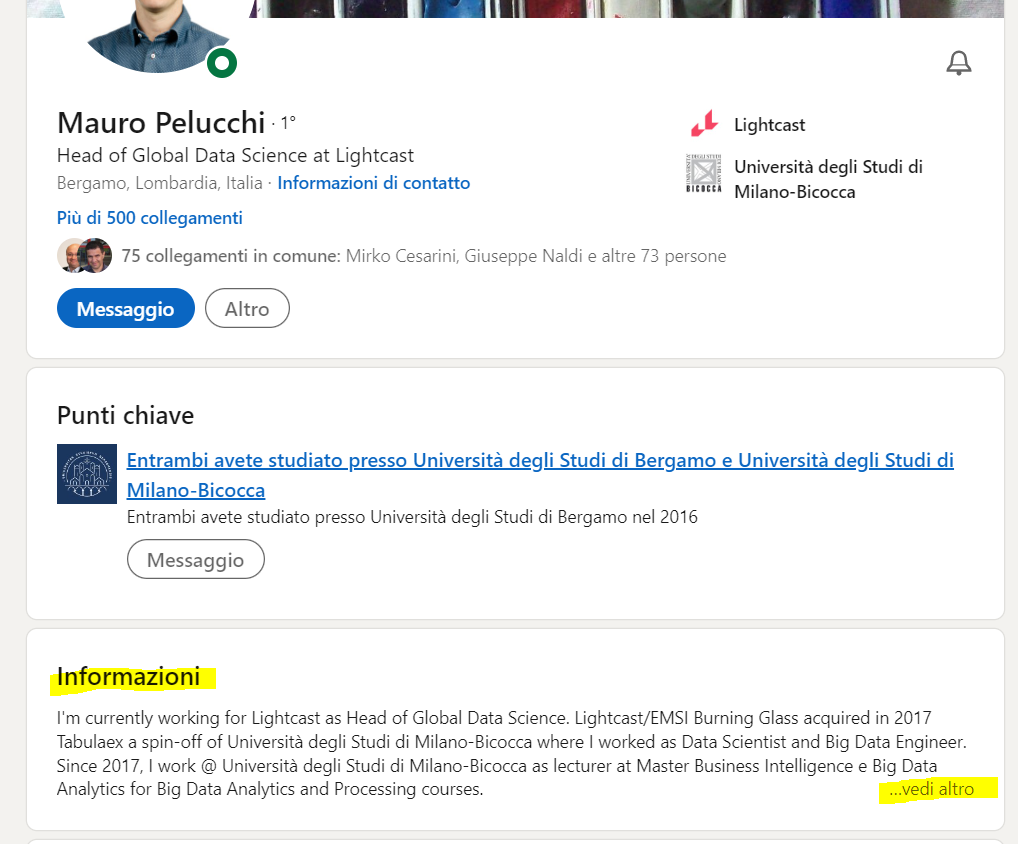

Voglio poi tutti i dati sulle esperienze di lavoro.

In questo caso ogni esperienza di lavoro può avere o no il link "...vedi altro". 

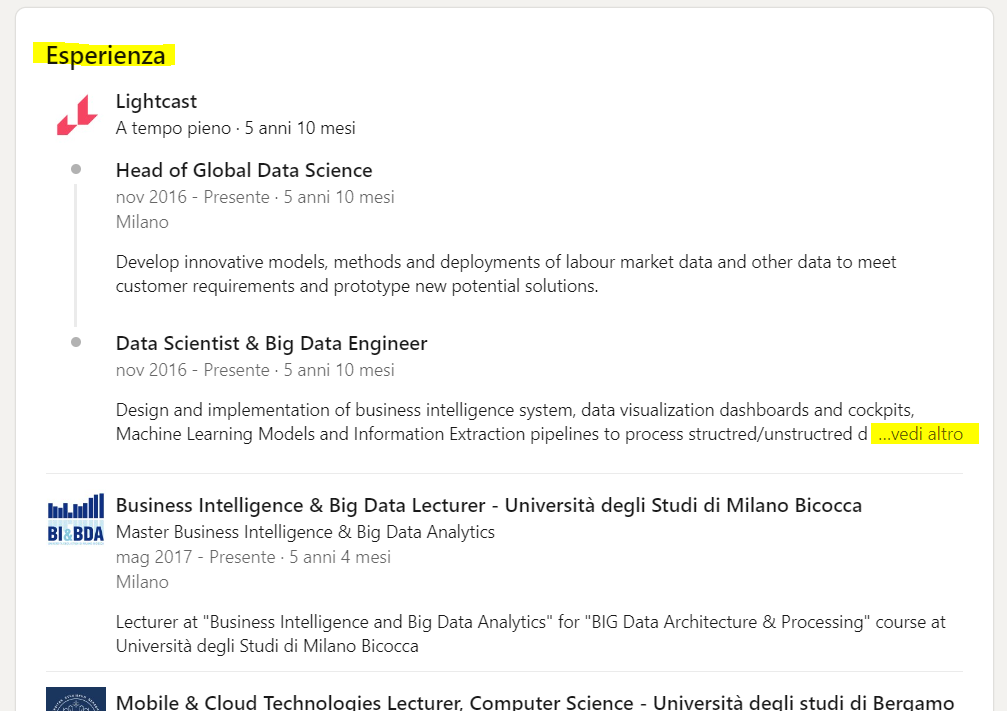

Ma in più la sezione "Esperienza" può avere o non avere diversi ruoli all'interno della stessa azienda (il caso di Lightcast) e avere un link per espandere tutte le esperienze.

In questo caso cliccando su "Mostra tutte le esperienze", verranno espansi anche tutti i contenuti prima parzialmente nascosti dal link "...vedi altro"


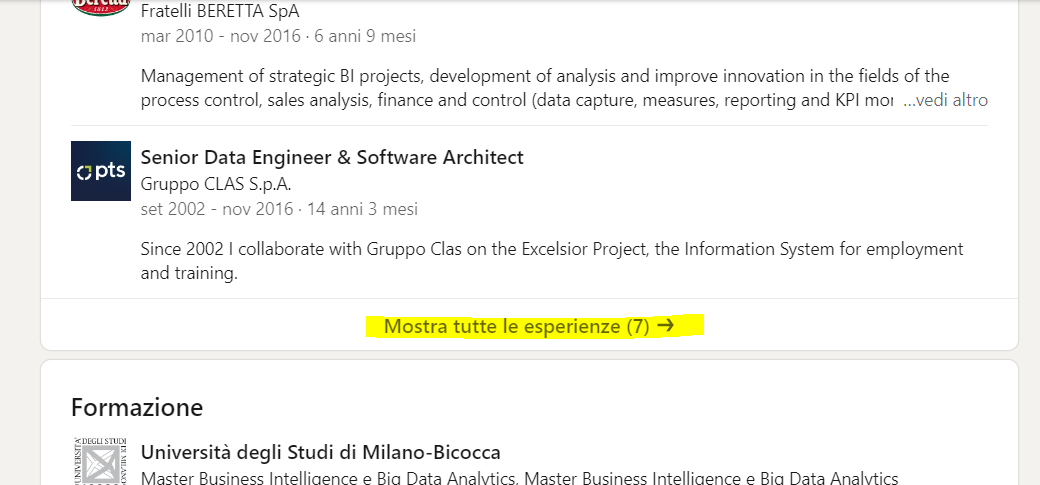

Come sopra, le stesse cose valgono anche per la sezione "Formazione"

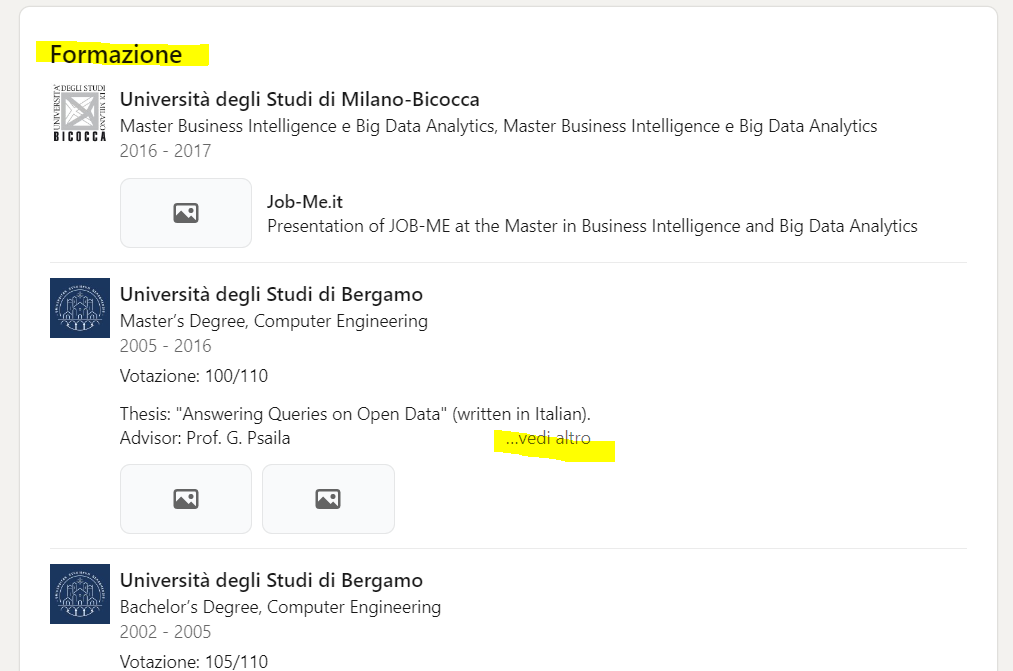

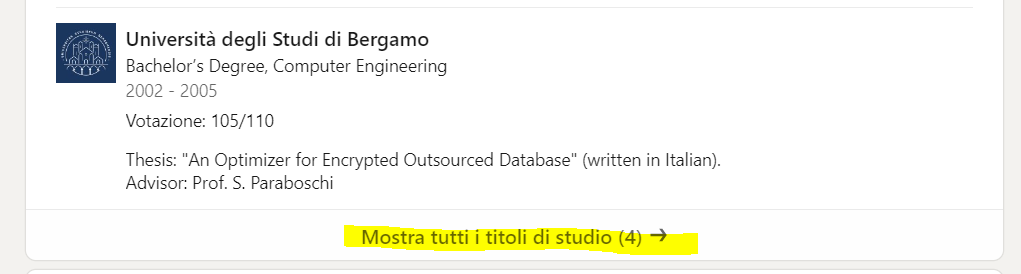

Infine mi interessano i dati relativi alle certificazioni. Stessi discorsi di prima con la differenza che qui non comparirà mai il link "...vedi altro"

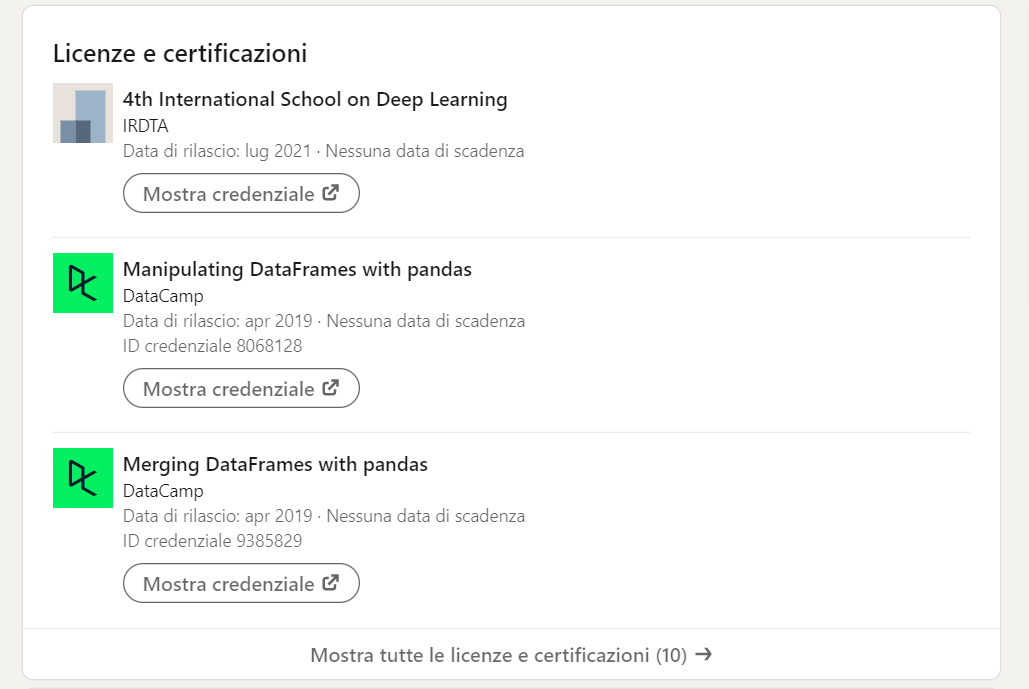

### Scraping della sezione "Informazioni"

Procedo passo passo facendo 4 df distinti su cui poi farò join come meglio credo in base alle esigenze.

Inzio con lo scraping di "Informazioni".

I campi che comporranno il file .csv finale saranno:


`info` *(corrisponde al testo nella sezione "Informazioni" del profilo)*

`_id` *(**primary key**: corrisponde all'url LinkedIn dell'user a cui applicherò l'hash)*

`url_user` *(corrisponde all'url LinkedIn dell'user)*

`name_user` *(corrisponde al nome in LinkedIn dell'user)*

`name_uni` *(corrisponde al nome in LinkedIn dell'università da cui proviene il link del profilo dell'user)*

`url_uni` *(corrisponde all'url LinkedIn dell'università da cui proviene il link del profilo dell'user)*

`_id_uni` *(**foreign key**: corrisponde all'hash del link LinkedIn dell'università)*

`url_uni_ex_st` *(corrisponde all'url del link LinkedIn della pagina degli studenti dell'università da cui proviene il link del profilo dell'user)*

`last_update` *(data dell'ultimo update)*

In [22]:
today = date.today()
user_list = pd.read_csv(f'{staging_area}list_users_{today}.csv') # today potrebbe essere diverso. Modificare manualmente nel caso.
user_list.shape[0]

4621

In [23]:
user_list

,url_user,name_user,_id_uni,_id,last_update,name_uni,url_uni,url_uni_ex_st
0,https://www.linkedin.com/in/florianaalbertoni/,Floriana Albertoni,69ed8a17f1b166675f48ca338c63bf97,dd3bedbc7f817828ce43970955083609,2022-08-10,Università IULM,https://www.linkedin.com/school/iulm-university/,https://www.linkedin.com/school/iulm-university/people/
1,https://www.linkedin.com/in/valentina-colleoni-6ab73049/,valentina colleoni,69ed8a17f1b166675f48ca338c63bf97,7f34ee73d937588dd94a87591c15cdbd,2022-08-10,Università IULM,https://www.linkedin.com/school/iulm-university/,https://www.linkedin.com/school/iulm-university/people/
2,https://www.linkedin.com/in/matteo-normanni/,Matteo Normanni,69ed8a17f1b166675f48ca338c63bf97,bce1fb9753663c551338aa39dec823fd,2022-08-10,Università IULM,https://www.linkedin.com/school/iulm-university/,https://www.linkedin.com/school/iulm-university/people/
3,https://www.linkedin.com/in/massimiliano-celeri/,Massimiliano Celeri,69ed8a17f1b166675f48ca338c63bf97,f438660607312be8c2ea7082bc99f8a6,2022-08-10,Università IULM,https://www.linkedin.com/school/iulm-university/,https://www.linkedin.com/school/iulm-university/people/
4,https://www.linkedin.com/in/luca-andreini-856b99145/,Luca Andreini,69ed8a17f1b166675f48ca338c63bf97,d63c83c7fe3989c5bffd4d9b612726e9,2022-08-10,Università IULM,https://www.linkedin.com/school/iulm-university/,https://www.linkedin.com/school/iulm-university/people/
...,...,...,...,...,...,...,...,...
4616,https://www.linkedin.com/in/annunziata-di-verniere/,Annunziata Di Verniere,a0e6d88092081e3a5566d41dd97a0dd2,9626cd7179fafb9ef92f58e328d31131,2022-08-10,Università degli Studi di Salerno,https://www.linkedin.com/school/unisalerno/,https://www.linkedin.com/school/unisalerno/people/
4617,https://www.linkedin.com/in/francesco-fontana-4183b4166/,Francesco Fontana,a0e6d88092081e3a5566d41dd97a0dd2,34241412c8116567005bbc9f877a67c9,2022-08-10,Università degli Studi di Salerno,https://www.linkedin.com/school/unisalerno/,https://www.linkedin.com/school/unisalerno/people/
4618,https://www.linkedin.com/in/mariacristinafolino/,Maria Cristina Folino,a0e6d88092081e3a5566d41dd97a0dd2,37e9d5a3d2a79e0406af8cd3503d740f,2022-08-10,Università degli Studi di Salerno,https://www.linkedin.com/school/unisalerno/,https://www.linkedin.com/school/unisalerno/people/
4619,https://www.linkedin.com/in/rossellaronca/,Rossella Ronca,a0e6d88092081e3a5566d41dd97a0dd2,a8266858677b08d4f313bebe69abe63e,2022-08-10,Università degli Studi di Salerno,https://www.linkedin.com/school/unisalerno/,https://www.linkedin.com/school/unisalerno/people/


In [ ]:
# divido in subset come fatto prima. Non fate più di 150/200 chiamate alla volta (ma regolatevi voi)
user_list_30 = user_list.iloc[:30,:]
user_list_60 = user_list.iloc[30:60,:]
user_list_90 = user_list.iloc[60:90,:]
user_list_120 = user_list.iloc[90:120,:]
user_list_150 = user_list.iloc[120:150,:]
user_list_180 = user_list.iloc[150:180,:]
user_list_end = user_list.iloc[180:,:]

In [ ]:
# qui il codice per fare scraping del campo "Informazioni"
inf = [] # lista vuota
controllo = [] # lista vuota di controllo
n = 0 # imposto un contatore per uscire dal try una volta finito il for loop
for index, project in tqdm(user_list_30.iterrows(), total = user_list_30.shape[0]): # solito loop
  delay = randint(4,8) # ad ogni ciclo for imposto tempi di attesa causali tra 4 e 8 secondi
  _id = project['_id'] # prendo l'id che mi servirà per il join
  url =  project['url_user']
  name_user =  project['name_user']
  time.sleep(delay)
  wd.get(url)

  try: # provo a cercare l'elemento ""...vedi altro", se c'è clicco e prendo le info.
    view_more = wd.find_element(By.CLASS_NAME, "inline-show-more-text__button.inline-show-more-text__button--light.link")
    # attenzione, se cercate il class_name in chrome e lo copiate avrete la stringa con spazi. Sostituire gli spazi con .
    view_more.send_keys(Keys.ENTER) # clicca sull'elemento
    informazioni = wd.find_element(By.CLASS_NAME, "pv-shared-text-with-see-more.t-14.t-normal.t-black.display-flex.align-items-center").text
    # trova l'elemento html e convertilo in testo (o prendi la parte di testo del codice html, fa una delle due cose, non ricordo)
    print(f"{name_user} - {url}: ok")
    inf.append({'info': informazioni,
                '_id': _id
                })
    controllo.append({'name_user': name_user,
                      'url': url,
                      'controllo' : True
                      })

  except: # se non c'è l'elemento cliccabile ci sono 2 possibilità: o le info sono solo da prendere o non ci sono proprio
    if(len(wd.find_element(By.CLASS_NAME, "pv-shared-text-with-see-more.t-14.t-normal.t-black.display-flex.align-items-center"))  > 0):
      informazioni = wd.find_element(By.CLASS_NAME, "pv-shared-text-with-see-more.t-14.t-normal.t-black.display-flex.align-items-center").text
      # trova l'elemento html e convertilo in testo (o prendi la parte di testo del codice html, fa una delle due cose, non ricordo)
      print(f"{name_user} - {url}: ok")
      inf.append({'info': informazioni,
                  '_id': _id
                  })
      controllo.append({'name_user': name_user,
                        'url': url,
                        'controllo' : True
                        })
      
    else:
      print(f"{name_user} - {url}: empty")
      inf.append({'info': np.nan,
                '_id': _id
                })
      controllo.append({'name_user': name_user,
                        'url': url,
                        'controllo' : False
                        })

  0%|          | 0/30 [00:00<?, ?it/s]

Claudia Silenzi - https://www.linkedin.com/in/claudia-silenzi-89a8b7159/: empty
Gloria Burzoni - https://www.linkedin.com/in/gloriaburzoni/: ok
Irene Luraghi - https://www.linkedin.com/in/irene-luraghi-7463b71a1/: ok
Paolo Pagani - https://www.linkedin.com/in/paolo-pagani-051b12137/: ok
Valentina F. - https://www.linkedin.com/in/valentina-f-5b550296/: ok
Giulia Crippa - https://www.linkedin.com/in/giulia-crippa-a55751a2/: ok
Asia Gotti - https://www.linkedin.com/in/asiagotti/: empty
Lucrezia P. - https://www.linkedin.com/in/lucreziapolitti/: empty
Cristiana Storelli - https://www.linkedin.com/in/cristiana-storelli-59454919a/: ok
Elena Sola - https://www.linkedin.com/in/elena-sola-154038b3/: empty
Valeria Galbiati - https://www.linkedin.com/in/valeria-galbiati-9029b774/: ok
Valeria Borghi - https://www.linkedin.com/in/valeria-borghi/: ok
Marica Biasi - https://www.linkedin.com/in/marica-biasi-98522b234/: ok
Laura Poli - https://www.linkedin.com/in/laura-poli-a49a1210a/: ok
Elisa Bellini

In [ ]:
inf = pd.DataFrame(inf)
controllo = pd.DataFrame(controllo)
controllo.to_excel(staging_area + "controllo_info.xlsx", index=False)

negativi = controllo[controllo["controllo"]==False] # visualizzo solo i record andati male
negativi
# posso a campione aprire qualche link per verificare che effettivamente non ci sia la sezione "Informazioni"

# Come capire se il codice si è rotto e il find_element è da aggiornare?
if inf.shape[0] == negativi.shape[0]:
  print("Attenzione! Non è stato trovato nulla! Tutti i controlli sono negativi! Il codice di find_element è da aggiornare")

NameError: ignored

In [ ]:
# controllo che ci sia tutto e non di meno o di più
positivi = controllo[controllo["controllo"]==True]
positivi.shape[0] + negativi.shape[0] == user_list_30.shape[0]

True

In [ ]:
info(inf)

Overview of dataframe 
 
 
 
 columns 
 rows 
 rows_whitout_NaN 
 rows_whit_NaN 
 rows_duplicate 
 rows_unique 
 memory_usage 
 
 
 
 
 dataframe 
 2 
 30 
 22 
 8 
 0 
 30 
 31.47 KB 
 
 
 Features 
 
 
 
 dtypes 
 not_NaN 
 NaN 
 unique 
 top 
 freq 
 min_len 
 max_len 
 
 
 
 
 info 
 object 
 22 
 8 
 22 
 “𝗦𝗶 𝗿𝗲𝗮𝗹𝗶𝘇𝘇𝗮𝗻𝗼 𝘀𝗲𝗺𝗽𝗿𝗲 𝗹𝗲 𝗰𝗼𝘀𝗲 𝗶𝗻 𝗰𝘂𝗶 𝗰𝗿𝗲𝗱𝗶 𝗿𝗲𝗮𝗹𝗺𝗲𝗻𝘁𝗲; 𝗲 𝗶𝗹 𝗰𝗿𝗲𝗱𝗲𝗿𝗲 𝗶𝗻 𝘂𝗻𝗮 𝗰𝗼𝘀𝗮 𝗹𝗮 𝗿𝗲𝗻𝗱𝗲 𝗽𝗼𝘀𝘀𝗶𝗯𝗶𝗹𝗲."\n 𝗙𝗿𝗮𝗻𝗸 𝗟𝗹𝗼𝘆𝗱 𝗪𝗿𝗶𝗴𝗵𝘁\n\n\nDopo una laurea magistrale in Arti, Patrimoni e Mercati èpresso l'università IULM di Milano, ho approfondito sul campo le mie competenze di comunicazione e social media marketing. Ho curato campagne Google ADS, svolto attività di SEO/SEM per migliorare il posizionamento di siti web nei motori di ricerca, ho svolto attività di content marketing, gestito interamente un e-commerce e ho svolto artività di ufficio stampa per importanti eventi nazionali.\n\nSono una persona molto attiva e piena di interessi, dalla musica (suono il sax), al cinema (ho collaborato con un'organizzazione di festival di cortometraggi) allo sport (nel tempo libero amo tenermi in forma).\n\nHo partecipato a fiere nazionali e internazionali in differenti settori: dall'alimentare all'ambito artistico-cinematografico operando per promuovere aziende, servizi o festival.\n\n\nContatti:\n✉️gloriaburzoni@gmail.com\n\n📞3485127661 
 1 
 3 
 2327 
 
 
 _id 
 object 
 30 
 0 
 30 
 74682d680991d4ee290e908d9425b435 
 1 
 32 
 32 
 
 
 Sample of dataframe 
 
 
 
 info 
 _id 
 
 
 
 
 12 
 Grazie al mio percorso accademico e professionale ho compreso il ruolo strategico della comunicazione sia interna che esterna; apprendendo i processi, gli strumenti e le modalità per la realizzazione di comunicazioni efficaci in linea con gli obiettivi, il posizionamento e i valori dell'organizzazione.\nGrazie al mio percorso accademico e professionale ho compreso il ruolo strategico della comunicazione sia interna che esterna; apprendendo i processi, gli strumenti e le modalità per la realizzazione di comunicazioni efficaci in linea con gli obiettivi, il posizionamento e i valori dell'organizzazione. 
 47fccbc6f134fd246584eb064b8f16d4 
 
 
 21 
 I have always been fascinated by the power of words connecting people. This is why I strongly believe in the potential of communication, which acts as a bridge, capable to put organizations into contact with their stakeholders. \nSince I am a person who is always willing to learn, my expectation for the future is that of working in a stimulating and dynamic environment where I can further develop my professional profile.\nI have always been fascinated by the power of words connecting people. This is why I strongly believe in the potential of communication, which acts as a bridge, capable to put organizations into contact with their stakeholders. Since I am a person who is always willing to learn, my expectation for the future is that of working in a stimulating and dynamic environment where I can further develop my professional profile. 
 25852ec2ae5450630bc5c5ca04934519 
 
 
 6 
 NaN 
 58a7cf0b78efa5209e9a231432d29cd0

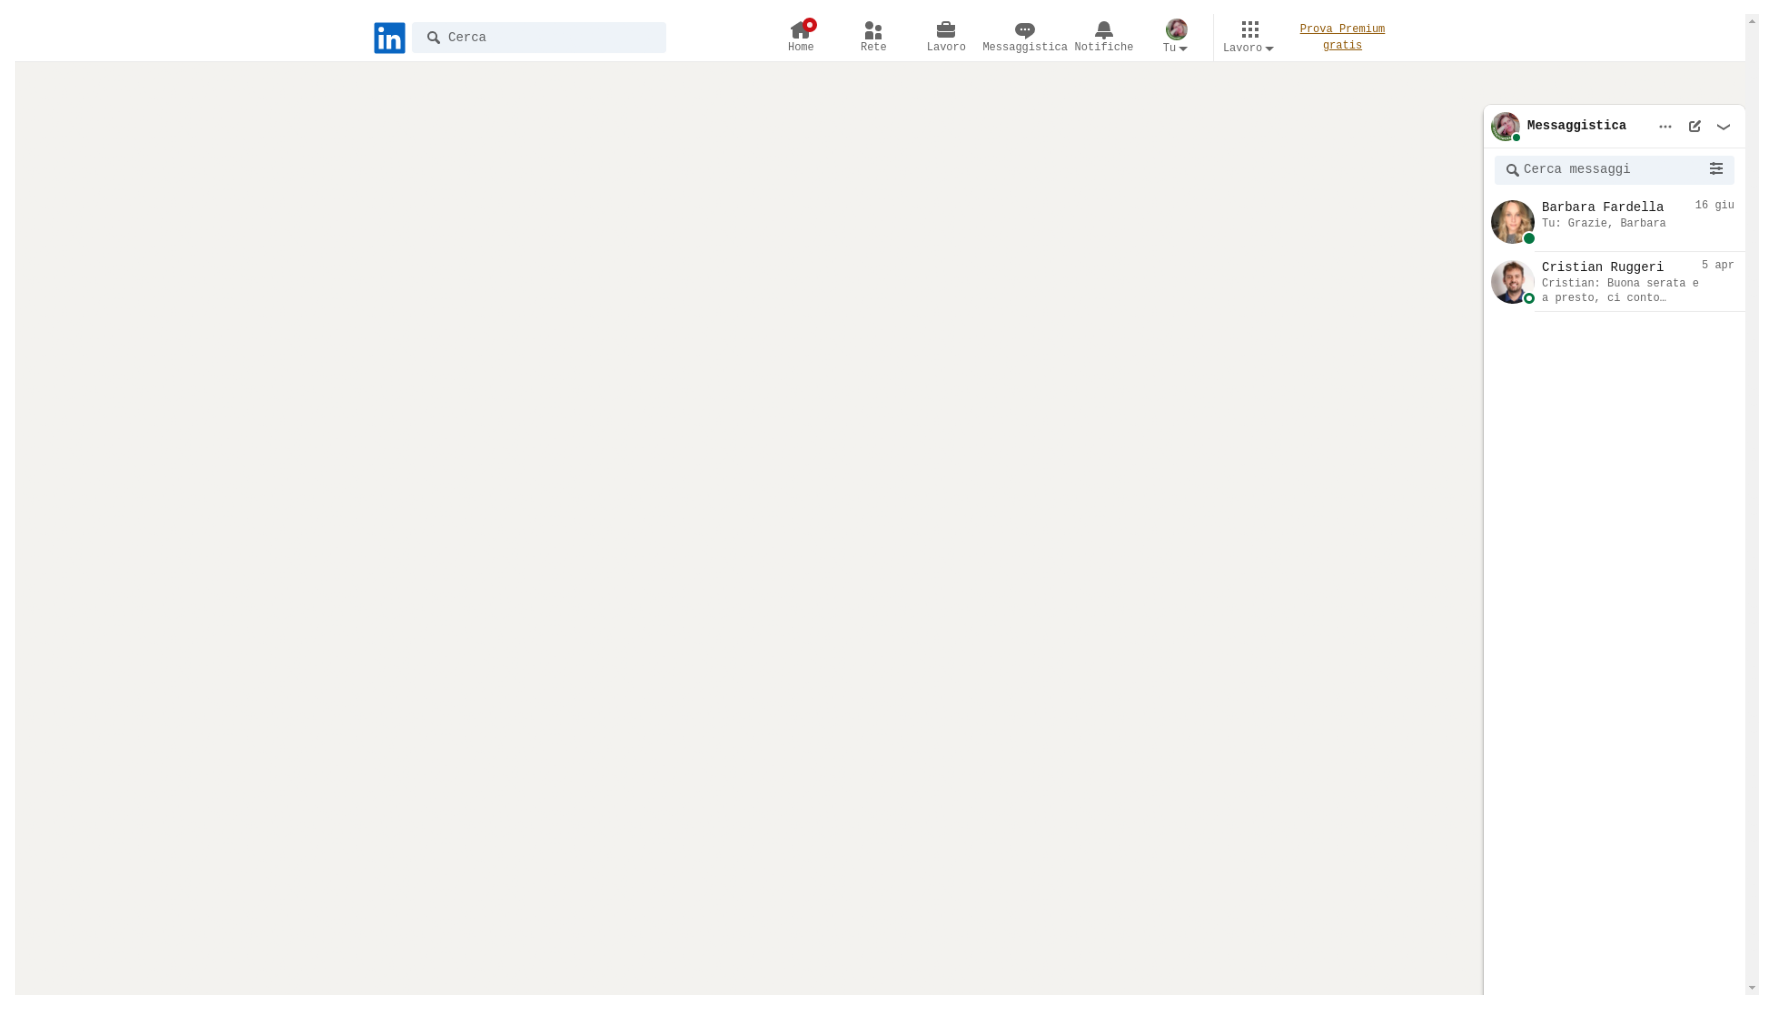

In [ ]:
view()

In [ ]:
# metto join
result = pd.merge(inf, user_list, how="left", left_on="_id", right_on="_id", suffixes=("_user", "_info"), validate="many_to_one")

In [ ]:
result.columns

Index(['info', '_id', 'url_user', 'name_user', '_id_uni', 'last_update',
       'name_uni', 'url_uni', 'url_uni_ex_st'],
      dtype='object')

In [ ]:
result['last_update'] = date.today() # aggiungo la data odierna
result = result.drop_duplicates(subset=['_id']) # elimino eventuali doppioni
result.to_csv(staging_area + "users_60.csv", index=False) # salvo

In [ ]:
# unisco tutti i csv. e salvo
for i in tqdm(glob.glob(f'{staging_area}users_*.csv')):
  try:
    basename = os.path.basename(i)
    os.rename(f'{staging_area}{basename}',f'{merge_area}{basename}')
    print(f'File moved')
  except Exception as e:
    print(e)

# ora unisco tutti i csv della cartella merge

# creo una lista di path di tutti i file che iniziano con list_users_ e finiscono con .csv
informazioni_raw_all_files = glob.glob(os.path.join(merge_area, "users_*.csv"))

# importo in pandas ogni file con un ciclo for (versione "slim") e inserisco tutto in una variabile
informazioni_raw_from_each_file = (pd.read_csv(f, sep=',') for f in informazioni_raw_all_files)

# concateno tutti i pd
informazioni_raw_merged = pd.concat(informazioni_raw_from_each_file, ignore_index=True)

# elimino i doppioni: uno stesso user potrebbe essere ex-alunno di due università diverse e me lo troverei 2 volte nel df
informazioni_raw_merged = informazioni_raw_merged.drop_duplicates(subset=['_id'])

today = date.today()
# salvo sia in excel (non si sa mai) che in csv
informazioni_raw_merged.to_csv(f'{ingest}users_info_{today}.csv', index=False)
print(f'{ingest}users_info_{today}.csv created')
informazioni_raw_merged.to_excel(f'{ingest}users_info_{today}.xlsx', index=False)
print(f'{ingest}users_info_{today}.xlsx created')

  0%|          | 0/2 [00:00<?, ?it/s]

File moved
File moved


Il file finale si chiama users_(data).csv

Ad ogni scrapig viene creato un nuovo file in modo da tenere traccia degli aggiornamenti. Il più recente sarà il più aggiornato ma i vecchi file non li butto: potrebbero servire per analisi di serie temporali.

Il testo del campo "info" andrà pulito (\n, emoji, •, ecc.) a seconda degli utilizzi che se ne faranno. Si tratta di dati non-strutturati.

### Scraping della sezione "Formazione"
coming soon

-----------------------------------------

Il concetto è sempre quello: parto dalla lista degli utenti e faccio scraping della sezione che mi serve.

Una volta su un profilo si può fare scraping di tutte e 4 le sezioni (Informazioni, Esperienza, Formazione, Licenze) in una sola volta, ma facendo così si è costretti a navigare tra le pagine alla ricerca di link, tornare poi indietro ecc.

Io qui le ho divise solo per una questione di ordine mentale, per semplicità (punto direttamente al link della sezione) e perchè potrebbe interessare lo scraping solo di una sezione!

Ovviamente **è meglio**, una volta che si è su un profilo, **prendere subito tutto quello che serve**, in questo modo si simulerebbe un comportamento più umano e il rischio di essere bloccati o bannati diminuisce. Però se si fa scraping in un contesto di lavoro/esercizio di gruppo, ognuno si può occupare però di una sezione, ciascuno usando account diversi, per poi mettere in join tutto quanto.

**Ogni record rappresenta una esperienza di studio di un utente LinkedIn.**


I campi che comporranno il file .csv finale saranno:


`school_name` *(corrisponde al nome della scuola)*

`edu_qual` *(corrisponde al tipo di titolo di studio)*

`period` *(al periodo di inzio-fine del percorso di studi)*

`school_grades` *(corrisponde alla votazione finale)*

`_id` *(**foreign key**: va in join con _id di "Informazioni", file* `{ingest}users_info_{today}.csv`

`last_update` *(data dell'ultimo update)*

In [ ]:
today = date.today()
user_list = pd.read_csv(f'{staging_area}list_users_{today}.csv') # today potrebbe essere diverso. Modificare manualmente nel caso.
user_list.shape[0]

4621

In [ ]:
# divido in subset come fatto prima. Non fate più di 150/200 chiamate alla volta (ma regolatevi voi)
user_list_30 = user_list.iloc[:30,:]
user_list_60 = user_list.iloc[30:60,:]
user_list_90 = user_list.iloc[60:90,:]
user_list_120 = user_list.iloc[90:120,:]
user_list_150 = user_list.iloc[120:150,:]
user_list_180 = user_list.iloc[150:180,:]
user_list_end = user_list.iloc[180:,:]

In [ ]:
sep = '\n'
education = []
today = date.today()

for index, row in tqdm(user_list_30.iterrows(), total = user_list_30.shape[0]): # solito loop
  delay = randint(4,8) # ad ogni ciclo for imposto tempi di attesa causali tra 4 e 8 secondi
  _id = row['_id'] # prendo l'id che mi servirà per il join
  url =  row['url_user']
  name_user =  row['name_user']
  time.sleep(delay)
  wd.get(f'{url}details/education/') # se non è stato aggiunto nulla all'user si viene comunque rimandati ad una
  # pagina linkedIn esistente, quindi non si vede nessun errore
  scroll(wd, 5)



  view_more = wd.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item.artdeco-list__item.pvs-list__item--line-separated")

  for i in view_more:

    if (len(i.find_elements(By.CLASS_NAME, "display-flex.align-items-center")) > 0):
      school_name = i.find_elements(By.CLASS_NAME, "display-flex.align-items-center")[0].text
      school_name = school_name.split(sep, 1)[0]
    
    else:
      school_name = np.nan
      print(f'{name_user} - {url}: no school_name')
    
    if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal")) > 0):
      edu_qual = i.find_elements(By.CLASS_NAME, "t-14.t-normal")[0].text
      edu_qual = edu_qual.split(sep, 1)[0]
    
    else:
      edu_qual = np.nan
      print(f'{name_user} - {url} - {school_name}: no edu_qual')
    
    if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")) > 0):
      period = i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")[0].text
      period = period.split(sep, 1)[0]

    else:
      period = np.nan
      print(f'{name_user} - {url} - {school_name}: no period')

    if (len(i.find_elements(By.CLASS_NAME, "display-flex.mv1.link-without-hover-visited")) > 0):
      school_grades = i.find_elements(By.CLASS_NAME, "display-flex.mv1.link-without-hover-visited")[0].text
      school_grades = school_grades.split(sep, 1)[0]

    else:
      school_grades = np.nan
      print(f'{name_user} - {url} - {school_name}: no school_grades')
    
    education.append({'school_names': school_name,
                      'edu_qual': edu_qual,
                      'school_grades': school_grades,
                      'period': period,
                      '_id': _id,
                      'last_update': today
                      })

  0%|          | 0/30 [00:00<?, ?it/s]

Floriana Albertoni - https://www.linkedin.com/in/florianaalbertoni/ - Liceo linguistico statale Giovanni Falcone: no period


In [ ]:
education = pd.DataFrame(education)

# elimino la colonna '_id_univ'
col = ['_id', 'last_update'] # creo una lista con i nomi di colonne da eliminare

controllo = education.loc[:, ~education.columns.isin(col)]
# .loc che prende tutti i record :, e tutte le colonne che NON sono nella lista col

count_values = controllo.shape[0]*controllo.shape[1]
count_nan = controllo.isnull().sum().sum()

if count_values == count_nan:
  print("Non è stato trovato nessun elemento! LinkedIn ha modificato il suo codice. Bisogna aggiornare i find_elements")

else:
  print(f'Ci sono {count_values} valori di cui {count_nan} nulli. Il Codice dei find_elements è ancora valido.')

In [ ]:
education.to_csv(staging_area + "education_30.csv", index=False) # salvo

In [ ]:
# unisco tutti i csv. e salvo
for i in tqdm(glob.glob(f'{staging_area}education_*.csv')):
  try:
    basename = os.path.basename(i)
    os.rename(f'{staging_area}{basename}',f'{merge_area}{basename}')
    print(f'File moved')
  except Exception as e:
    print(e)

# ora unisco tutti i csv della cartella merge

# creo una lista di path di tutti i file che iniziano con list_users_ e finiscono con .csv
education_raw_all_files = glob.glob(os.path.join(merge_area, "education_*.csv"))

# importo in pandas ogni file con un ciclo for (versione "slim") e inserisco tutto in una variabile
education_raw_from_each_file = (pd.read_csv(f, sep=',') for f in education_raw_all_files)

# concateno tutti i pd
education_raw_merged = pd.concat(education_raw_from_each_file, ignore_index=True)

# elimino i doppioni: si sa mai che abbia fatto casino con le liste.
education_raw_merged = education_raw_merged.drop_duplicates()

today = date.today()
# salvo sia in excel (non si sa mai) che in csv
education_raw_merged.to_csv(f'{ingest}users_education_{today}.csv', index=False)
print(f'{ingest}users_education_{today}.csv created')
education_raw_merged.to_excel(f'{ingest}users_education_{today}.xlsx', index=False)
print(f'{ingest}users_education_{today}.xlsx created')

### Scraping della sezione "Licenze e Certificazioni"
coming soon

In [ ]:
today = date.today()
user_list = pd.read_csv(f'{staging_area}list_users_{today}.csv') # today potrebbe essere diverso. Modificare manualmente nel caso.
user_list.shape[0]

In [ ]:
# divido in subset come fatto prima. Non fate più di 150/200 chiamate alla volta (ma regolatevi voi)
user_list_30 = user_list.iloc[:30,:]
user_list_60 = user_list.iloc[30:60,:]
user_list_90 = user_list.iloc[60:90,:]
user_list_120 = user_list.iloc[90:120,:]
user_list_150 = user_list.iloc[120:150,:]
user_list_180 = user_list.iloc[150:180,:]
user_list_end = user_list.iloc[180:,:]

In [ ]:
sep = '\n'
certificate = []
today = date.today()

for index, row in tqdm(user_list_30.iterrows(), total = user_list_30.shape[0]): # solito loop
  delay = randint(4,8) # ad ogni ciclo for imposto tempi di attesa causali tra 4 e 8 secondi
  _id = row['_id'] # prendo l'id che mi servirà per il join
  url =  row['url_user']
  name_user =  row['name_user']
  time.sleep(delay)
  wd.get(f'{url}details/certifications/')
  scroll(wd, 5)

  view_more = wd.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item.artdeco-list__item.pvs-list__item--line-separated")
  for i in view_more:
    if (len(i.find_elements(By.CLASS_NAME, "display-flex.align-items-center")) > 0):
      certificate_name = i.find_elements(By.CLASS_NAME, "display-flex.align-items-center")[0].text
      certificate_name = certificate_name.split(sep, 1)[0]
    
    else:
      certificate_name = np.nan
      print(f'{name_user} - {url}: no certificate_name')
    
    if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal")) > 0):
      certifying_company = i.find_elements(By.CLASS_NAME, "t-14.t-normal")[0].text
      certifying_company = certifying_company.split(sep, 1)[0]
    
    else:
      certifying_company = np.nan
      print(f'{name_user} - {url} - {certificate_name}: no certifying_company')

    if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")) > 0):     
      date_issue_expiration = i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")[0].text
      date_issue_expiration = date_issue_expiration.split(sep, 1)[0]
    
    else:
      date_issue_expiration = np.nan
      print(f'{name_user} - {url} - {certificate_name}: no date_issue_expiration')

    
    certificate.append({'certificate_name': certificate_name,
                        'certifying_company': certifying_company,
                        'date_issue_expiration': date_issue_expiration,
                        '_id': _id,
                        'last_update': today
                  })

  0%|          | 0/30 [00:00<?, ?it/s]

current height: 1724
Floriana Albertoni - https://www.linkedin.com/in/florianaalbertoni/ - ECDL: no date_issue_expiration
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/: no certificate_name
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/ - nan: no certifying_company
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/ - nan: no date_issue_expiration
current height: 1173
Luca Andreini - https://www.linkedin.com/in/luca-andreini-856b99145/ - First certificate in English: no date_issue_expiration
current height: 553
current height: 921
Camilla Bernasconi - https://www.linkedin.com/in/camilla-bernasconi-042714128/: no certificate_name
Camilla Bernasconi - https://www.linkedin.com/in/camilla-bernasconi-042714128/ - nan: no certifying_company
Camilla Bernasconi - https://www.linkedin.com/in/camilla-bernasconi-042714128/ - nan: no date_issue_expiration
Luigi Conenna - https://www.linkedin.com/in/luigiconenna

In [ ]:
certificate = pd.DataFrame(certificate)

# elimino la colonna '_id_univ'
col = ['_id', 'last_update'] # creo una lista con i nomi di colonne da eliminare

controllo = certificate.loc[:, ~certificate.columns.isin(col)]
# .loc che prende tutti i record :, e tutte le colonne che NON sono nella lista col

count_values = controllo.shape[0]*controllo.shape[1]
count_nan = controllo.isnull().sum().sum()

if count_values == count_nan:
  print("Non è stato trovato nessun elemento! LinkedIn ha modificato il suo codice. Bisogna aggiornare i find_elements")

else:
  print(f'Ci sono {count_values} valori di cui {count_nan} nulli. Il Codice dei find_elements è ancora valido.')

Ci sono 189 valori di cui 60 nulli. Il Codice dei find_elements è ancora valido.


In [ ]:
certificate.to_csv(staging_area + "certificate_30.csv", index=False) # salvo

In [128]:
# unisco tutti i csv. e salvo
for i in tqdm(glob.glob(f'{staging_area}certificate_*.csv')):
  try:
    basename = os.path.basename(i)
    os.rename(f'{staging_area}{basename}',f'{merge_area}{basename}')
    print(f'File moved')
  except Exception as e:
    print(e)

# ora unisco tutti i csv della cartella merge

# creo una lista di path di tutti i file che iniziano con list_users_ e finiscono con .csv
certificate_raw_all_files = glob.glob(os.path.join(merge_area, "certificate_*.csv"))

# importo in pandas ogni file con un ciclo for (versione "slim") e inserisco tutto in una variabile
certificate_raw_from_each_file = (pd.read_csv(f, sep=',') for f in certificate_raw_all_files)

# concateno tutti i pd
certificate_raw_merged = pd.concat(certificate_raw_from_each_file, ignore_index=True)

# elimino i doppioni: si sa mai che abbia fatto casino con le liste.
certificate_raw_merged = certificate_raw_merged.drop_duplicates()

today = date.today()
# salvo sia in excel (non si sa mai) che in csv
certificate_raw_merged.to_csv(f'{ingest}users_certificate_{today}.csv', index=False)
print(f'{ingest}users_certificate_{today}.csv created')
certificate_raw_merged.to_excel(f'{ingest}users_certificate_{today}.xlsx', index=False)
print(f'{ingest}users_certificate_{today}.xlsx created')

  0%|          | 0/1 [00:00<?, ?it/s]

File moved
/content/drive/MyDrive/repo/scraping/linkedin/ingest/users_certificate_2022-08-17.csv created
/content/drive/MyDrive/repo/scraping/linkedin/ingest/users_certificate_2022-08-17.xlsx created


### Scraping della sezione "Esperienza"

**Ogni record rappresenta una posizione lavorativa di un utente LinkedIn in una azienda.**

Un utente può aver ricorperto nel tempo più posizione nella stessa azienda. Per ogni posizione ci sarà dunque un record.

<br>


I campi che comporranno il file .csv finale saranno:


`company_name` *(corrisponde al nome dell'azienda)*

`role` *(corrisponde alla posizione ricoperta nell'azienda)*

`period` *(corrisponde al periodo di inzio-fine del percorso lavorativo)*

`description` *(corrisponde alla descrizione della mansione)*

`_id` *(**foreign key**: va in join con _id di "Informazioni", file* `{ingest}users_info_{today}.csv`

`last_update` *(data dell'ultimo update)*

In [ ]:
today = date.today()
user_list = pd.read_csv(f'{staging_area}list_users_{today}.csv') # today potrebbe essere diverso. Modificare manualmente nel caso.
user_list.shape[0]

In [25]:
# divido in subset come fatto prima. Non fate più di 150/200 chiamate alla volta (ma regolatevi voi)
user_list_30 = user_list.iloc[:30,:]
user_list_60 = user_list.iloc[30:60,:]
user_list_90 = user_list.iloc[60:90,:]
user_list_120 = user_list.iloc[90:120,:]
user_list_150 = user_list.iloc[120:150,:]
user_list_180 = user_list.iloc[150:180,:]
user_list_end = user_list.iloc[180:,:]

In [124]:
sep = '\n'
experience = []
today = date.today()

for index, row in tqdm(user_list_30.iterrows(), total = user_list_30.shape[0]): # solito loop
  delay = randint(4,8) # ad ogni ciclo for imposto tempi di attesa causali tra 4 e 8 secondi
  _id = row['_id'] # prendo l'id che mi servirà per il join
  url =  row['url_user']
  name_user =  row['name_user']
  time.sleep(delay)
  wd.get(f'{url}details/experience/') # se non è stato aggiunto nulla all'user si viene comunque rimandati ad una
  # pagina linkedIn esistente, quindi non si vede nessun errore
  scroll(wd, 5)

    
  if (len(wd.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item.artdeco-list__item.pvs-list__item--line-separated")) > 0):

    view_more = wd.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item.artdeco-list__item.pvs-list__item--line-separated")
    for i in view_more: # per ogni contenitore di una esperienza lavorativa
      if (len(i.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item")) > 0): # se contiene più sezioni (quindi più ruoli)
        more_role = i.find_elements(By.CLASS_NAME, "pvs-list__paged-list-item")

        company_name = i.find_elements(By.CLASS_NAME, "display-flex.align-items-center")[0].text
        company_name = company_name.split(sep, 1)[0]

        for ii in more_role:
          if (len(ii.find_elements(By.CLASS_NAME, "display-flex.align-items-center")) > 0):
            role = ii.find_elements(By.CLASS_NAME, "display-flex.align-items-center")[0].text
            role = role.split(sep, 1)[0]

          else:
            print(f'{name_user} - {url} - {company_name}: no role')
            role = np.nan

          if (len(ii.find_elements(By.CLASS_NAME, "display-flex.align-items-center")) > 0):  
            period = ii.find_elements(By.CLASS_NAME, "t-14.t-normal")[0].text
            period = period.split(sep, 1)[0]

          else:
            print(f'{name_user} - {url} - {company_name}: no period')
            period = np.nan
          
          if (len(ii.find_elements(By.CLASS_NAME, "display-flex.align-items-center")) > 0):
            try: # nella descrizione potrebbe esserci solamente un link con immagine
              des = ii.find_elements(By.CLASS_NAME, "pvs-list__item--with-top-padding")[0].text
              des = des.split(sep)[-1]
            except:
              print(f'{name_user} - {url} - {company_name}: no description text')


          else:
            print(f'{name_user} - {url} - {company_name}: no description')
            des = np.nan

            experience.append({'company_name': company_name,
                  'role': role,
                  'period': period,
                  'description': des,
                  '_id': _id,
                  'last_update': today
                  })


      else:
        if (len(i.find_elements(By.CLASS_NAME, "mr1.t-bold")) > 0):
          role = i.find_elements(By.CLASS_NAME, "mr1.t-bold")[0].text
          role = role.split(sep, 1)[0]
        
        else:
          print(f'{name_user} - {url}: no role')
          role = np.nan

        if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal")) > 0):
          company_name = i.find_elements(By.CLASS_NAME, "t-14.t-normal")[0].text
          company_name = company_name.split(sep, 1)[0]
        else:
          print(f'{name_user} - {url}: no company_name')
          company_name = np.nan

        if (len(i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")) > 0):
          period = i.find_elements(By.CLASS_NAME, "t-14.t-normal.t-black--light")[0].text
          period = period.split(sep, 1)[0]
        else:
          print(f'{name_user} - {url}: no period')
          period = np.nan
        
        if (len(i.find_elements(By.CLASS_NAME, "pvs-list__item--with-top-padding")) > 0):
          des = i.find_elements(By.CLASS_NAME, "pvs-list__item--with-top-padding")[0].text
          des = des.split(sep)[-1]
        else:
          print(f'{name_user} - {url}: no description')
          des = np.nan
        
        experience.append({'company_name': company_name,
                          'role': role,
                          'period': period,
                          'description': des,
                          '_id': _id,
                          'last_update': today
                          })


        


  else:
    print(f'{name_user} - {url}: no data')
    experience.append({'company_name': np.nan,
                    'role': np.nan,
                    'period': np.nan,
                    'description': np.nan,
                    '_id': _id,
                    'last_update': today
                    })
          

  



  0%|          | 0/30 [00:00<?, ?it/s]

current height: 1990
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/: no description
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/: no description
valentina colleoni - https://www.linkedin.com/in/valentina-colleoni-6ab73049/: no description
current height: 1418
current height: 2748
current height: 3243
Luca Andreini - https://www.linkedin.com/in/luca-andreini-856b99145/: no description
Luca Andreini - https://www.linkedin.com/in/luca-andreini-856b99145/: no description
Luca Andreini - https://www.linkedin.com/in/luca-andreini-856b99145/: no description
Veronica Parolini - https://www.linkedin.com/in/veronica-parolini-83a64518b/: no description
Veronica Parolini - https://www.linkedin.com/in/veronica-parolini-83a64518b/: no description
Veronica Parolini - https://www.linkedin.com/in/veronica-parolini-83a64518b/: no description
current height: 2828
Camilla Bernasconi - https://www.linkedin.com/in/camilla-bernasconi-042714128/:

In [125]:
experience = pd.DataFrame(experience)

# elimino la colonna '_id_univ'
col = ['_id', 'last_update'] # creo una lista con i nomi di colonne da eliminare

controllo = experience.loc[:, ~experience.columns.isin(col)]
# .loc che prende tutti i record :, e tutte le colonne che NON sono nella lista col

count_values = controllo.shape[0]*controllo.shape[1]
count_nan = controllo.isnull().sum().sum()

if count_values == count_nan:
  print("Non è stato trovato nessun elemento! LinkedIn ha modificato il suo codice. Bisogna aggiornare i find_elements")

else:
  print(f'Ci sono {count_values} valori di cui {count_nan} nulli. Il Codice dei find_elements è ancora valido.')

Ci sono 564 valori di cui 46 nulli. Il Codice dei find_elements è ancora valido.


In [126]:
experience.to_csv(staging_area + "experience_30.csv", index=False) # salvo

In [129]:
# unisco tutti i csv. e salvo
for i in tqdm(glob.glob(f'{staging_area}experience_*.csv')):
  try:
    basename = os.path.basename(i)
    os.rename(f'{staging_area}{basename}',f'{merge_area}{basename}')
    print(f'File moved')
  except Exception as e:
    print(e)

# ora unisco tutti i csv della cartella merge

# creo una lista di path di tutti i file che iniziano con list_users_ e finiscono con .csv
experience_raw_all_files = glob.glob(os.path.join(merge_area, "experience_*.csv"))

# importo in pandas ogni file con un ciclo for (versione "slim") e inserisco tutto in una variabile
experience_raw_from_each_file = (pd.read_csv(f, sep=',') for f in experience_raw_all_files)

# concateno tutti i pd
experience_raw_merged = pd.concat(experience_raw_from_each_file, ignore_index=True)

# elimino i doppioni: si sa mai che abbia fatto casino con le liste.
experience_raw_merged = experience_raw_merged.drop_duplicates()

today = date.today()
# salvo sia in excel (non si sa mai) che in csv
experience_raw_merged.to_csv(f'{ingest}users_experience_{today}.csv', index=False)
print(f'{ingest}users_experience_{today}.csv created')
experience_raw_merged.to_excel(f'{ingest}users_experience_{today}.xlsx', index=False)
print(f'{ingest}users_experience_{today}.xlsx created')

  0%|          | 0/1 [00:00<?, ?it/s]

File moved
/content/drive/MyDrive/repo/scraping/linkedin/ingest/users_experience_2022-08-17.csv created
/content/drive/MyDrive/repo/scraping/linkedin/ingest/users_experience_2022-08-17.xlsx created


## Conclusione

In [ ]:
# Abbiamo 4 csv corrispondenti a 4 db, df o tabelle.
user_info = pd.read_csv(f'{ingest}users_info_{today}.csv')
user_ex = pd.read_csv(f'{ingest}users_experience_{today}.csv')
user_ed = pd.read_csv(f'{ingest}users_education_{today}.csv')
user_ce = pd.read_csv(f'{ingest}users_certificate_{today}.csv')
# su come mettere in join: https://pandas.pydata.org/docs/user_guide/merging.html
# _id in user_info è la chiave primaria, _id negli altri df sono chiavi esterne che permettono il join con user_info

Da qui in poi si lavora sulla pulizia del db.